### 1. Import files from Google Drive and extract them into data folder

In [33]:
import gdown
# Google drive public shared folder ID
id = "1vdm8b0ewDslPVvubA8emwDYHUGtwx5pT"
gdown.download_folder(id=id,output="../data", quiet=True, use_cookies=False)

['../data/bike_data.7z']

In [34]:
import py7zr
# Extract files from 7zip file
with py7zr.SevenZipFile('../data/bike_data.7z', mode='r') as z:
    z.extractall("../data")

#### 2. Read files

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", module = "matplotlib\..*" )
warnings.filterwarnings("ignore", module = "seaborn\..*" )

import pandas as pd

df = pd.read_csv('../data/accidentsVelo.csv',low_memory=False)
df.head()

Num_Acc        date    an     mois      jour   hrmn dep    com  \
0  200500000030  2005-01-13  2005  janvier     jeudi  19:45  62  62331   
1  200500000034  2005-01-19  2005  janvier  mercredi  10:45  62  62022   
2  200500000078  2005-01-26  2005  janvier  mercredi  13:15  02  02173   
3  200500000093  2005-01-03  2005  janvier     lundi  13:30  02  02810   
4  200500000170  2005-01-29  2005  janvier    samedi  18:30  76  76196   

      lat   long  ...  secuexist  equipement  obs  obsm  choc  manv  \
0    50.3   2.84  ...          0           0  0.0   2.0   8.0  11.0   
1       0      0  ...          0           0  0.0   2.0   1.0   1.0   
2       0      0  ...          1           2  0.0   2.0   1.0   1.0   
3  49.255  3.094  ...          0           0  0.0   2.0   3.0  21.0   
4       0      0  ...          1           9  0.0   2.0   4.0   2.0   

        vehiculeid  typevehicules  manoeuvehicules  numVehicules  
0  200500000030B02             18               17           1.0  
1  200500000034B02             10               15           1.0  
2  200500000078B02              7               15           1.0  
3  200500000093B02              7               21           1.0  
4  200500000170A01             10                2           1.0  

[5 rows x 39 columns]

### 3. Some columns have mixed type values. Lets start by removing NA's first on lat and long columns only

In [36]:
num_rows = len(df)
df = df.loc[(df["lat"].notna() & df["long"].notna())]
num_rows_not_na = len(df)
print("----\nRemoved NA's rows : %d\n----" % (num_rows -num_rows_not_na) )
df[["lat","long"]].info()

----
Removed NA's rows : 268
----
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74490 entries, 0 to 74757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lat     74490 non-null  object
 1   long    74490 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


### 4. Convert lat and long cols to float

In [37]:
df['lat'] = df['lat'].apply(lambda x: float(str(x).replace(',', '.')))
df['long'] = df['long'].apply(lambda x: float(str(x).replace(',', '.')))

df[["lat","long"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74490 entries, 0 to 74757
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     74490 non-null  float64
 1   long    74490 non-null  float64
dtypes: float64(2)
memory usage: 1.7 MB


### 5. Checking zeros on lat and long cols and total number of cols

In [38]:
count_lat = df['lat'].value_counts()[0]
count_long = df['long'].value_counts()[0]
rows = len(df)

results = pd.DataFrame(data={"lat_with_zero":[count_lat], "long_with_zero":[count_long],"Total number of rows": [rows]})
results

lat_with_zero  long_with_zero  Total number of rows
0          42084           43131                 74490

### 6. Remove rows where lat and long columns are not 0

In [39]:
df_filtered = df.loc[(df['lat'] != 0) & (df['long'] != 0)].copy()
print("Non zero coordinates data frame has %d rows" %(len(df_filtered)))

Non zero coordinates data frame has 31355 rows


### 7. Convert to a proper geodataframe

epsg:4326


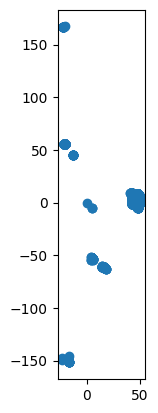

In [40]:
import geopandas as gp
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.lat, df_filtered.long))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326')
points_gdf.plot(aspect='equal')
print(points_gdf.crs)

#### Its seems the coordinates are inverted, let's fix this

epsg:27561


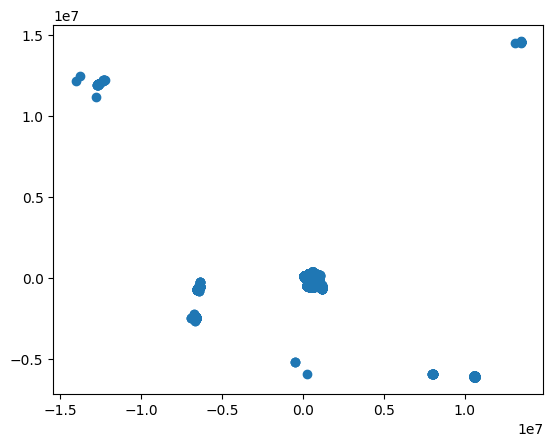

In [41]:
# Convert longitude and latitude to a geometric Point object
points_gdf = gp.GeoDataFrame(df_filtered, geometry=gp.points_from_xy(df_filtered.long, df_filtered.lat))
# Convert DataFrame to GeoDataFrame
points_gdf = points_gdf.set_crs('epsg:4326').to_crs('epsg:27561')
points_gdf.plot()
print(points_gdf.crs)

### 8. Plot France department limits, bike accident points and exclude points not falling in France

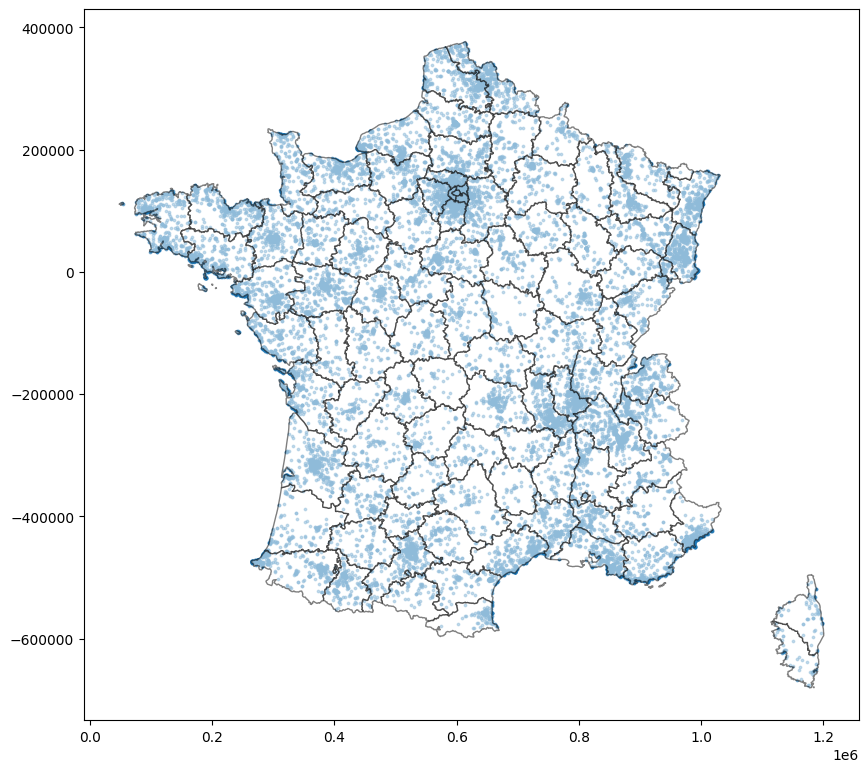

In [42]:
import matplotlib.pyplot as plt

france_gdf = gp.read_file("../data/france_dep.geojson")
france_gdf = france_gdf.to_crs('epsg:27561')

points_within = gp.sjoin(points_gdf,france_gdf,predicate='within')

ax = points_within.plot(legend=True, markersize=3,alpha=0.5,figsize=(10,10))
france_gdf.plot(ax=ax, color='white', alpha=0.5, edgecolor="k")
plt.show()

#### 9. Checking if the gravity of the accident can have a pattern

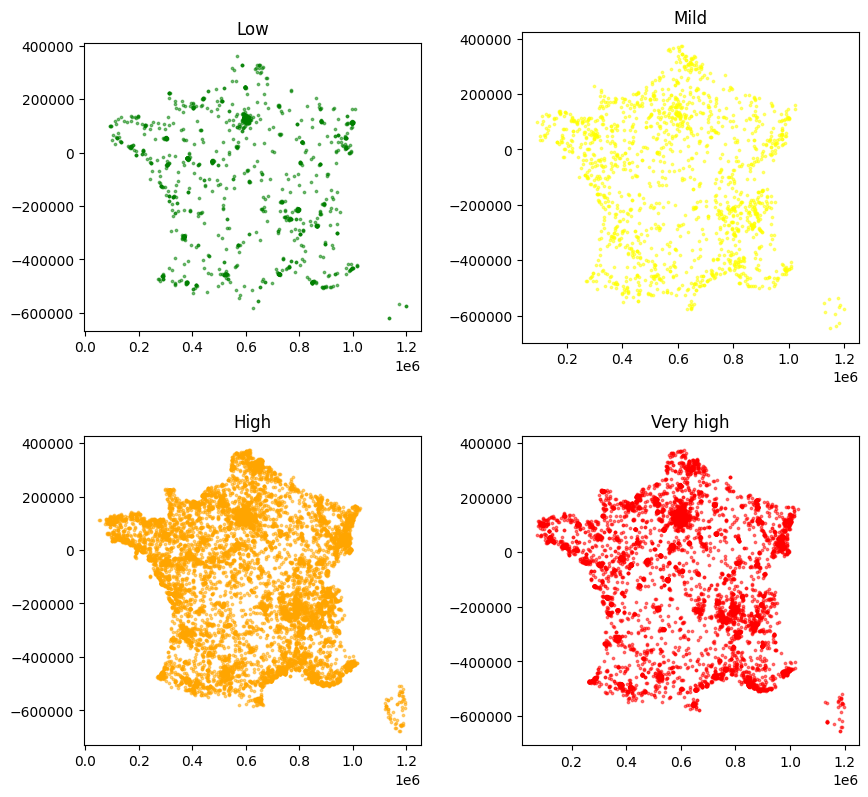

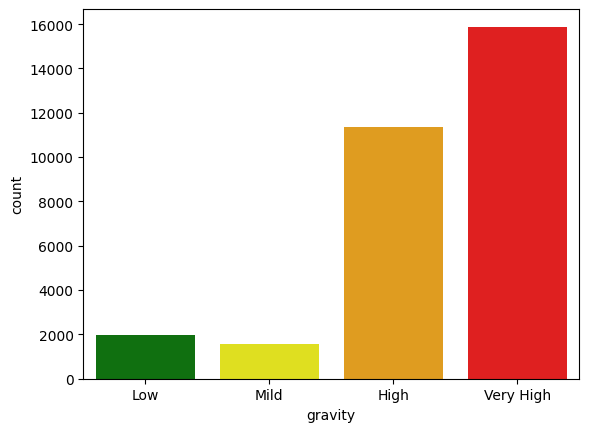

In [43]:
import seaborn as sns

fig, axs = plt.subplots(2, 2)


points_within_grav_1 = points_within.loc[points_within['grav'] == 1]
points_within_grav_1.plot(ax=axs[0, 0],markersize=3,alpha=0.5,color='green')
axs[0, 0].set_title("Low")

points_within_grav_2 = points_within.loc[points_within['grav'] == 2]
points_within_grav_2.plot(ax=axs[0, 1],markersize=3,alpha=0.5,color='yellow')
axs[0, 1].set_title("Mild")

axs[1, 0].sharex(axs[0, 0])

points_within_grav_3 = points_within.loc[points_within['grav'] == 3]
points_within_grav_3.plot(ax=axs[1, 0],markersize=3,alpha=0.5,color='orange')
axs[1, 0].set_title("High")

points_within_grav_4 = points_within.loc[points_within['grav'] == 4]
points_within_grav_4.plot(ax=axs[1, 1],markersize=3,alpha=0.5,color='red')
axs[1, 1].set_title("Very high")

fig.set_size_inches(10,10)

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()

gravity_df = pd.DataFrame(data={"Low":len(points_within_grav_1),
                                'Mild':len(points_within_grav_2),
                                "High":len(points_within_grav_3),
                                "Very High":len(points_within_grav_4)
                                },index=[0]).melt(var_name='gravity',value_name='count')

# Ploting also a bar plot
sns.barplot(data=gravity_df, x='gravity',y='count',palette=['green', 'yellow', 'orange', 'red'])
plt.show()

Despite the fact that the number of accidents informed as 'very high' gravity are higher than others, it seems that all accidents are spatially well distributed across the country. It is also evident that the number of accidents are concentrated in certain areas. Still, the gravity of an accident may also be subjective (or not well informed) in many cases. Since we are interested in where the accidents are occurring, let's instead check the density of accidents by region population, no matter the accident's gravity

#### 10. Merge accidents with department population

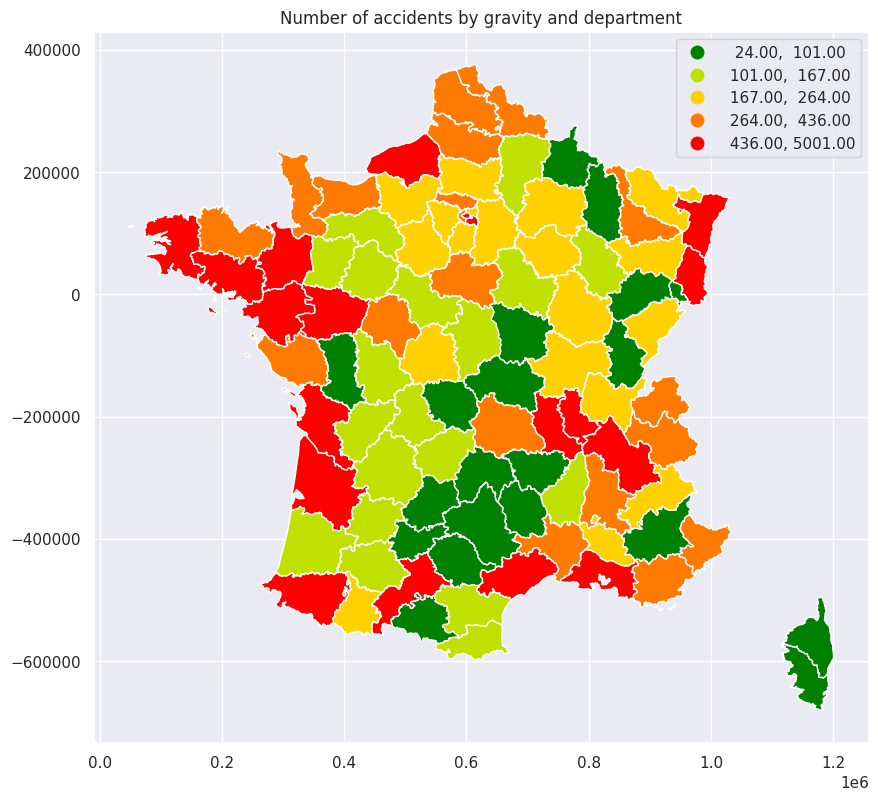

In [200]:
from matplotlib import colors

# Merge accudents with population data
accidents_by_department = points_gdf.sjoin(france_gdf,predicate='within')


# Select relevelant columns and initialize a col, since grav contains numbers from 1 to 4
accidents_by_department_acc = accidents_by_department[['nom', 'geometry']].copy()
accidents_by_department_acc['total_acc'] = 1

# Agregate (group) the sum of accidents (points) by deparment column, resulting in 96 multipoints rows per department
accidents_by_region = accidents_by_department_acc.dissolve(by='nom', aggfunc='sum',numeric_only=False)

# Remove index field names
france_gdf = france_gdf.loc[:,~france_gdf.columns.str.startswith('index_')]
accidents_by_region= accidents_by_region.loc[:,~accidents_by_region.columns.str.startswith('index_')]

# Merge france admin boundries with the previous aggregated data containing the sum
departments_by_accidents = gp.sjoin(france_gdf,accidents_by_region,how="inner",predicate="intersects")

# Define a palette of colors
cmap = colors.LinearSegmentedColormap.from_list("", ["green","yellow","orange","red"])

# Plot using quantiles as scheme
departments_by_accidents.plot(column = 'total_acc',scheme='quantiles', cmap=cmap,figsize=(10,10),legend=True);
plt.title("Number of accidents by gravity and department")
plt.show()

# Other scheme possibilities
# boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 'jenkscaspall', 'jenkscaspallforced', 
#'jenkscaspallsampled', 'maxp', 'maximumbreaks', 'naturalbreaks', 'quantiles', 'percentiles', 'prettybreaks', 'stdmean', 'userdefined'

### Quantile classification is well suited to linearly (evenly) distributed data, since we can have the same number of features or values in each class. However, the resulting map can often be misleading when the data is not evenly distributed, which is precisely our case :

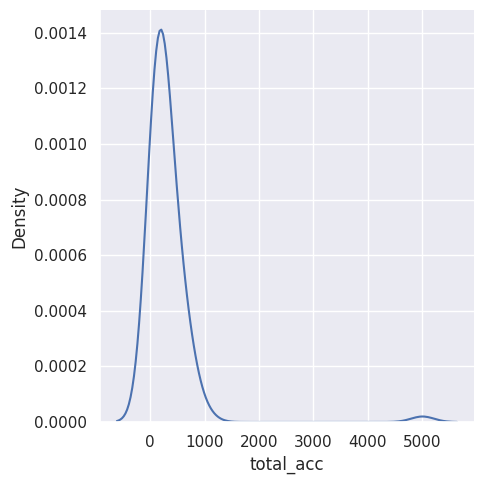

In [201]:
sns.displot(departments_by_accidents,x="total_acc", kind="kde")
plt.show()

In [202]:
departments_by_accidents[["nom","total_acc"]].sort_values("total_acc",ascending=False)

nom  total_acc
36                  Paris       5001
82         Maine-et-Loire        994
5         Ille-et-Vilaine        892
54                Gironde        704
33   Pyrénées-Atlantiques        703
..                    ...        ...
81                    Lot         56
48           Corse-du-Sud         49
95  Territoire de Belfort         38
30                 Lozère         37
50                 Creuse         24

[96 rows x 2 columns]

#### This map would reflect better the reality of our data : 

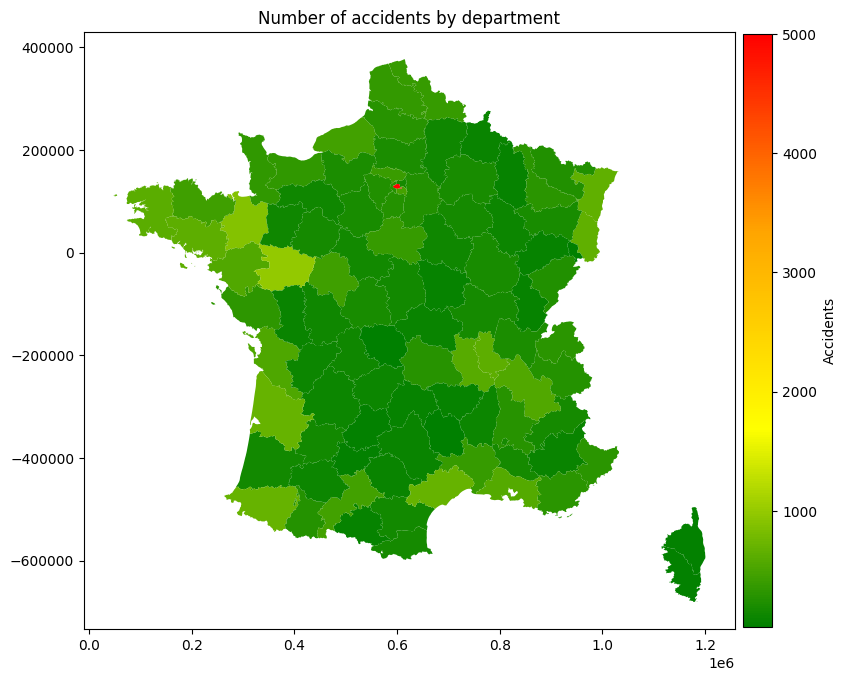

In [47]:
# Plot using without quantilles
departments_by_accidents.plot(column = 'total_acc', cmap=cmap,figsize=(10,10),legend=True,legend_kwds={
                    "shrink":.77,
                    "format": "%g",
                    'label': "Accidents",
                    "pad": 0.01,
                    #"ticks" : legend_intervals
                });
plt.title("Number of accidents by department")
plt.show()

#### 11. By using equal intervals, the total number of accidents in Paris is way higher than in most regions of france. Let's make the same plot by using region population instead, and plot the number of accidents per 1000 habitants

In [48]:
# Removing spaces and upper cases from cols of both dataframes
accidents_by_region.columns = [x.lower().replace(' ','') for x in accidents_by_region.columns]
accidents_by_department.columns = [x.lower().replace(' ','') for x in accidents_by_department.columns]

#### Load population data

In [49]:
population = pd.read_excel('../data/TCRD_004.xlsx',index_col=[0])
population_filtered = population[['nom','2023 (p)']].copy().rename(columns = {'2023 (p)':'pop_2023'})
population_filtered

nom  pop_2023
01                      Ain    671937
02                    Aisne    522791
03                   Allier    332443
04  Alpes-de-Haute-Provence    166654
05             Hautes-Alpes    139942
..                      ...       ...
91                  Essonne   1316053
92           Hauts-de-Seine   1642002
93        Seine-Saint-Denis   1682806
94             Val-de-Marne   1426748
95               Val-d'Oise   1274374

[96 rows x 2 columns]

#### Plot the number of accidents per 1000 habitants by department

<Axes: >

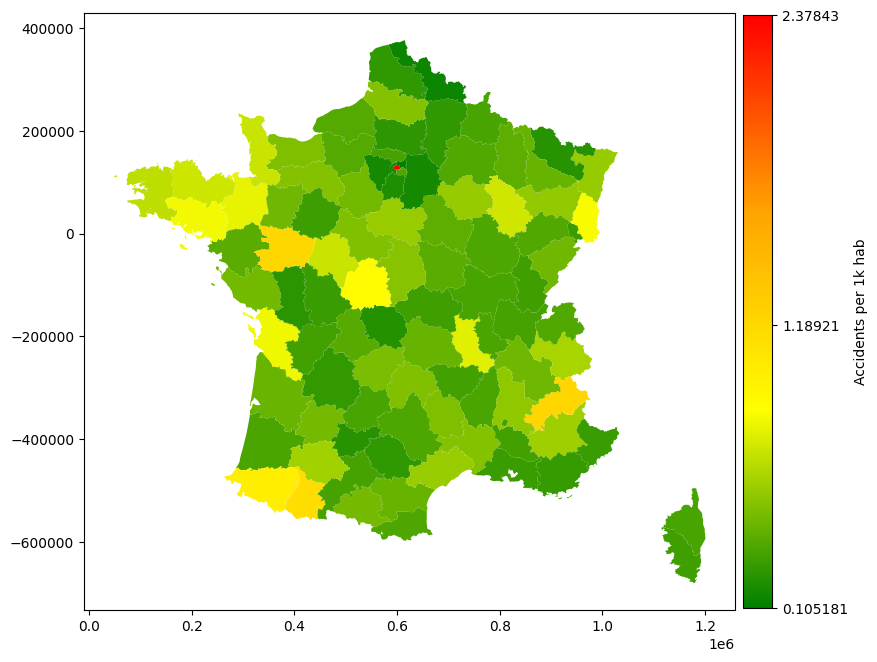

In [50]:
region_by_accidents_pop2023 = departments_by_accidents.merge(population_filtered,on='nom')
region_by_accidents_pop2023['acc_per_hab'] = (region_by_accidents_pop2023['total_acc'] / region_by_accidents_pop2023['pop_2023']) * 1000
region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(10)
region_by_accidents_pop2023.plot(column='acc_per_hab',cmap=cmap,legend=True,figsize=(10,10),legend_kwds={
                    "shrink":.77,
                    "format": "%g",
                    'label': "Accidents per 1k hab",
                    "pad": 0.01,
                    "ticks" : [min(region_by_accidents_pop2023['acc_per_hab']),
                               max(region_by_accidents_pop2023['acc_per_hab']) / 2, 
                               max(region_by_accidents_pop2023['acc_per_hab'])]
                })

#### 12. Check if the cyclable rods can provide more info

<Axes: >

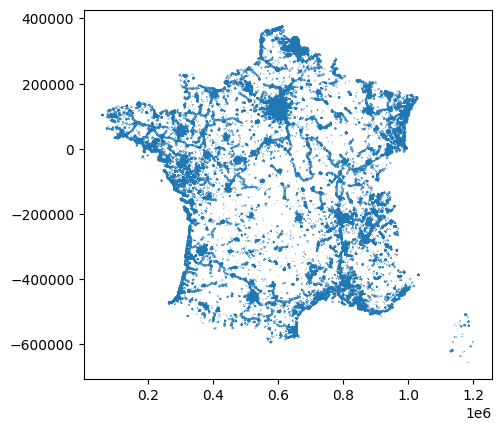

In [51]:
pistes_cyclable = gp.read_file("../data/france-20230901.geojson")
pistes_cyclable = pistes_cyclable.to_crs('epsg:27561')
pistes_cyclable.plot()

In [52]:
pistes_cyclable.columns

Index(['id_local', 'id_osm', 'num_iti', 'code_com_d', 'ame_d', 'regime_d',
       'sens_d', 'largeur_d', 'local_d', 'statut_d', 'revet_d', 'code_com_g',
       'ame_g', 'regime_g', 'sens_g', 'largeur_g', 'local_g', 'statut_g',
       'revet_g', 'access_ame', 'date_maj', 'trafic_vit', 'lumiere',
       'd_service', 'source', 'project_c', 'ref_geo', 'geometry'],
      dtype='object')

Let's start by checking the sum of NA values in the track bicycle dataframe : 

In [53]:
print(pistes_cyclable.isna().sum().sort_values())
print("\n TOTAL NUMBER OF ROWS : ",len(pistes_cyclable))

id_local           0
project_c          0
source             0
date_maj           0
statut_g           0
ref_geo            0
ame_g              0
statut_d           0
geometry           0
id_osm             0
ame_d             13
sens_d            61
code_com_d       207
code_com_g       210
regime_d       39857
trafic_vit     41559
sens_g         57355
regime_g       90601
revet_g       110912
revet_d       110912
local_g       203361
local_d       203798
lumiere       223554
num_iti       258774
access_ame    260307
largeur_d     279564
largeur_g     280775
d_service     291759
dtype: int64

 TOTAL NUMBER OF ROWS :  293816


There are many columns with too many NA values. We keep the columns with an acceptable number of NAs and the relevant ones. Next, we drop all rows with Na values

In [54]:
# Eliminate non relevant cols and col with too many NA values
pistes_cyclable_non_null_cols = pistes_cyclable[['date_maj','statut_g','ame_g',
                                                 'statut_d','geometry','ame_d','sens_d',
                                                 'code_com_d','code_com_g']]
# Drop rows
pistes_cyclable_filtered = pistes_cyclable_non_null_cols.dropna()
# Show some rows
pistes_cyclable_filtered.head(3)


date_maj    statut_g       ame_g    statut_d  \
0  2021-07-25  EN SERVICE  VOIE VERTE  EN SERVICE   
1  2013-01-21  EN SERVICE       AUTRE  EN SERVICE   
2  2013-01-21  EN SERVICE       AUTRE  EN SERVICE   

                                            geometry       ame_d  \
0  LINESTRING (411941.578 -496613.093, 411959.247...  VOIE VERTE   
1  LINESTRING (411750.821 -533429.458, 411753.708...       AUTRE   
2  LINESTRING (411763.145 -533389.922, 411764.163...       AUTRE   

            sens_d code_com_d code_com_g  
0  UNIDIRECTIONNEL      65226      65226  
1  UNIDIRECTIONNEL      65089      65424  
2  UNIDIRECTIONNEL      65424      65424

Now, we apply spatial join between the cleaned bike track and the accidents dataframes and we add the population dataframe

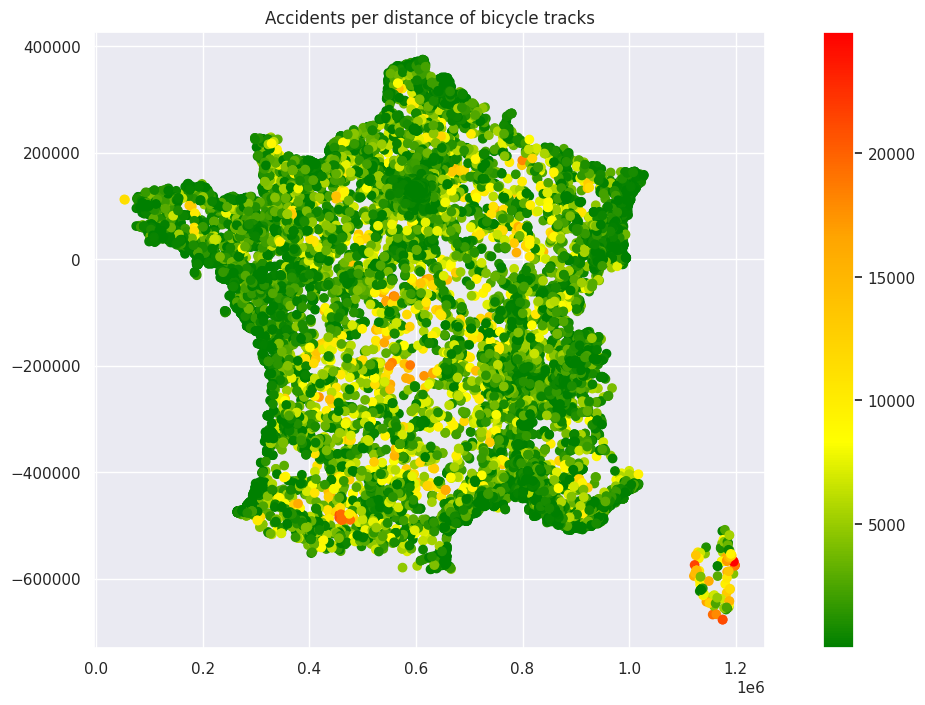

In [230]:
# Remove cols starting with index_
accidents_by_department = accidents_by_department.loc[:,~accidents_by_department.columns.str.startswith('index_')]
# Apply spatial join
accidents_by_department_with_tracks = accidents_by_department.sjoin_nearest(pistes_cyclable_filtered,how='left', distance_col="distances")

# Plot
ax = accidents_by_department_with_tracks.plot(column='distances',legend=True,cmap=cmap,figsize=(15,8))
ax.title.set_text("Accidents per distance of bicycle tracks")

# 14. Bicycle tracks on paris

Visualize the top 5 accident regions in france

In [231]:
top5 = region_by_accidents_pop2023.sort_values(by=['acc_per_hab'],ascending=[False]).head(5)
print(top5[['nom','pop_2023']])
paris = top5.head(1)
paris

                     nom  pop_2023
36                 Paris   2102650
21          Hautes-Alpes    139942
82        Maine-et-Loire    828269
60       Hautes-Pyrénées    230583
33  Pyrénées-Atlantiques    697899


code    nom                                           geometry index_right  \
36   75  Paris  POLYGON ((598781.702 133337.696, 603566.179 13...       Paris   

    total_acc  pop_2023  acc_per_hab  
36       5001   2102650     2.378427

And extract all track bicycles from Paris

<Axes: >

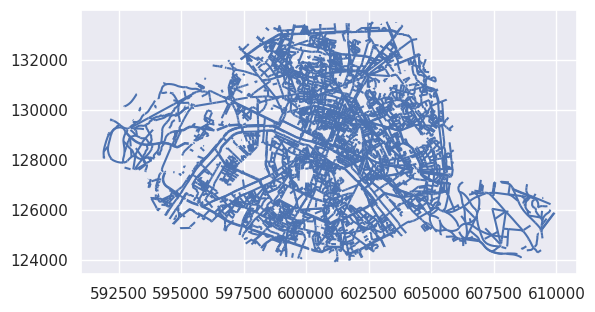

In [232]:
# Remove cols starting with index_
paris = paris.loc[:,~paris.columns.str.startswith('index_')]

pistes_cyclable_filtered_paris = gp.sjoin(pistes_cyclable_filtered, paris, predicate='intersects')
pistes_cyclable_filtered_paris.plot()

Since there are too many null values regarding track material, acess type and presence of ligtht, let's explore track type and track direction. We start by track type (ame_d) : 

In [233]:
# Starting by track type
pistes_cyclable_filtered_paris_type_track = pistes_cyclable_filtered_paris.loc[pistes_cyclable_filtered_paris['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_filtered_paris_type_track['ame_d'].isnull().sum())

Number of track types with null values :  0


Extract accidents occured in Paris only

<Axes: >

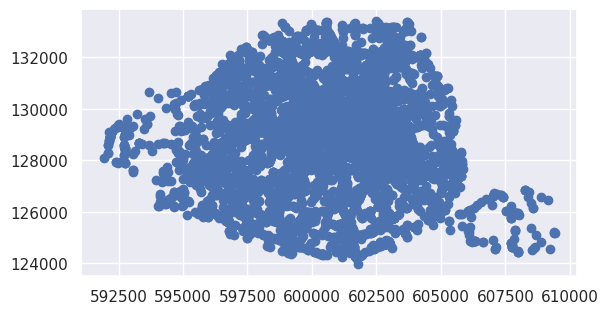

In [238]:
accidents_by_department = accidents_by_department.loc[:,~accidents_by_department.columns.str.startswith('index_')]
accidents_paris = gp.sjoin(accidents_by_department, paris, predicate='within')
accidents_paris.plot()

Plot track types with accidents

<Axes: >

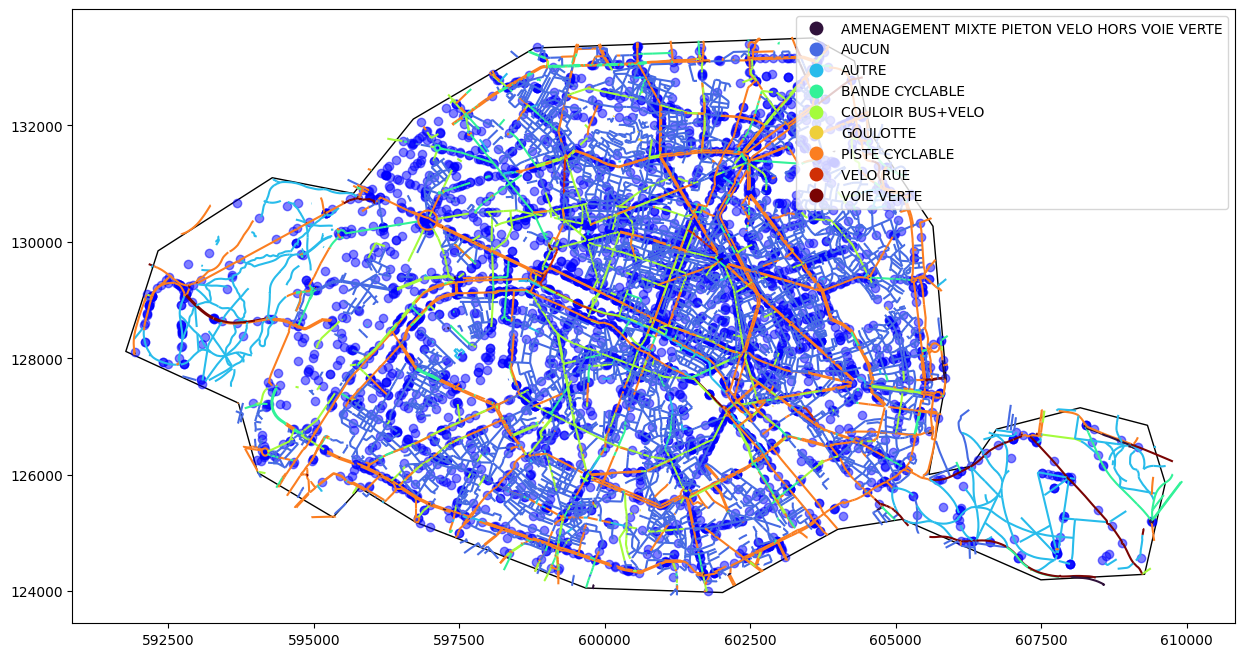

In [110]:
ax = paris.plot(color="white", edgecolor="black", figsize=(15, 8))

# Drop cols with index_ suffix
pistes_cyclable_filtered_paris_type_track = pistes_cyclable_filtered_paris_type_track.loc[:,~pistes_cyclable_filtered_paris_type_track.columns.str.startswith('index_')]
accidents_by_department = accidents_by_department.loc[:,~accidents_by_department.columns.str.startswith('index_')]
paris = paris.loc[:,~paris.columns.str.startswith('index_')]

# Intersect tracks with paris
region_intersect_track_type = gp.sjoin(pistes_cyclable_filtered_paris_type_track, paris, predicate='intersects')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_type["ame_d"].unique(), list(reversed(["green","yellow","orange","red"])))
# Plot tracks and accidents and paris
region_intersect_track_type.plot(ax=ax,cmap='turbo',column='ame_d',legend=True)
accidents_paris.plot(ax=ax,color="blue",legend=True,alpha=0.5)

There doesnt seem to have a direct relation between accidents and track type. Lets see about the track direction

In [111]:
pistes_cyclable_filtered_paris_direction_track = pistes_cyclable_filtered_paris.loc[pistes_cyclable_filtered_paris['ame_d'].notnull()]
print("Number of track types with null values : ", pistes_cyclable_filtered_paris['ame_d'].isnull().sum())

Number of track types with null values :  0


<Axes: >

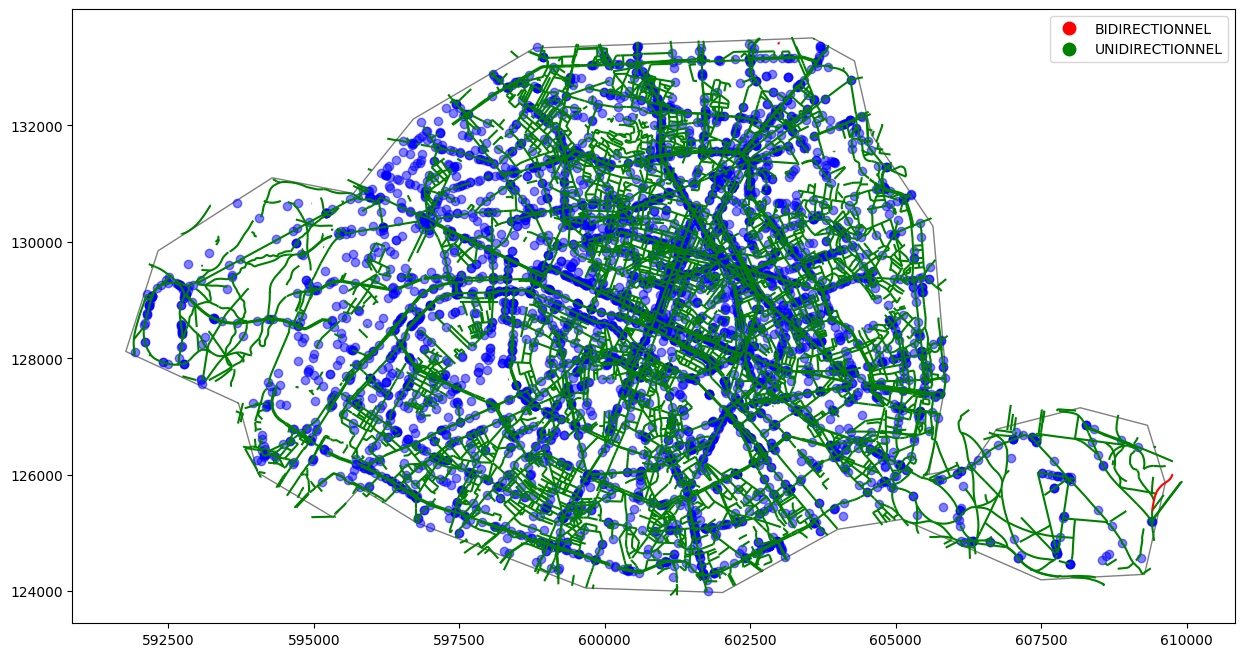

In [112]:
# Intersect tracks with paris

ax = paris.plot(color="white", edgecolor="black",alpha=0.5, figsize=(15, 10))

# Drop cols with index_ suffix

pistes_cyclable_filtered_paris_direction_track = pistes_cyclable_filtered_paris_direction_track.loc[:,~pistes_cyclable_filtered_paris_direction_track.columns.str.startswith('index_')]
accidents_by_department = accidents_by_department.loc[:,~accidents_by_department.columns.str.startswith('index_')]
paris = paris.loc[:,~paris.columns.str.startswith('index_')]

# Intersect tracks directions with paris
region_intersect_track_direction = gp.sjoin(pistes_cyclable_filtered_paris_direction_track, paris, predicate='intersects')
# Define a colormap
region_intersect_cmap = colors.LinearSegmentedColormap.from_list(region_intersect_track_direction["sens_d"].unique(), list(reversed(["green","red"])))

region_intersect_track_direction.plot(ax=ax,column='sens_d',cmap=region_intersect_cmap,legend=True)
accidents_paris.plot(ax=ax,color='blue',legend=True,alpha=0.5)

# Paris accidents by period of the year

Hot encoding day of the week, month, day, hour and min

In [239]:
import numpy as np
import datetime

# Make onehot encoding on jour and mois column as int, since the default is boolean type 
one_hot_jour = pd.get_dummies(accidents_paris['jour'],dtype=int)

# Extract year month and day (but use only month and day)
year_month_day = accidents_paris["date"].apply(lambda x: pd.Series(str(x).split("-")))

# Drop hot encoded cols and date
accidents_paris = accidents_paris.drop('jour',axis = 1)
accidents_paris = accidents_paris.drop('date',axis = 1)
# Split str hour:min into two columns and convert to numeric
accidents_paris[['hour', 'min']] = accidents_paris["hrmn"].apply(lambda x: pd.Series(str(x).split(":")))
# Drop accidents where registered hour is greater than 23
accidents_paris = accidents_paris.drop(accidents_paris.loc[accidents_paris['hour'].astype('int') > 23].index)
# Fill min column with 30 where minute chars are empty
accidents_paris['min'] = np.where( (accidents_paris['min'].str.len() < 1) , 30, accidents_paris['min'])
# Convert hour and min to int32
accidents_paris[['hour', 'min']] = accidents_paris[['hour', 'min']].astype('int')
# Join the hotencoded columns to the dataframe
accidents_paris = accidents_paris.join(one_hot_jour)
accidents_paris["month"] = year_month_day[1].astype('int')
accidents_paris["day"] = year_month_day[2].astype('int')
# Add datetime column
accidents_paris['datetime'] = accidents_paris[['an', 'month', 'day', 'hour','min']].apply(lambda s : datetime.datetime(*s),axis = 1)
# Top 3
accidents_paris.head(3)

Num_Acc    an     mois   hrmn dep    com       lat     long  agg  \
30208  201000062968  2010  octobre  18:45  75  75112  48.83464  2.43893    2   
30209  201000062968  2010  octobre  18:45  75  75112  48.83464  2.43893    2   
34199  201100046853  2011      mai  16:00  92  92051  48.87640  2.25041    2   

       int  ...  dimanche  jeudi  lundi  mardi  mercredi  samedi  vendredi  \
30208    1  ...         1      0      0      0         0       0         0   
30209    1  ...         1      0      0      0         0       0         0   
34199    1  ...         0      0      0      0         0       0         1   

       month day            datetime  
30208     10   3 2010-10-03 18:45:00  
30209     10   3 2010-10-03 18:45:00  
34199      5   6 2011-05-06 16:00:00  

[3 rows x 58 columns]

Define month order and plot accidents by month and hour of day

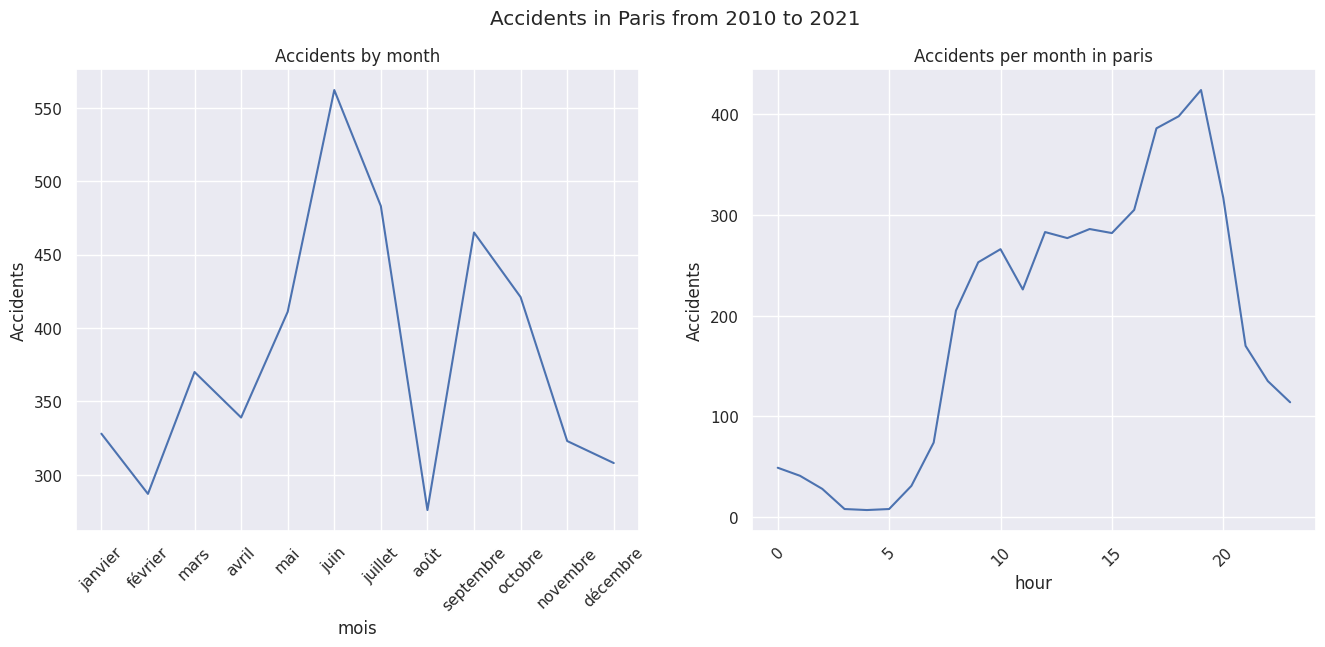

In [241]:
months = list(accidents_by_department['mois'].unique()).sort
months_order = ['janvier', 'février', 'mars', 'avril',
          'mai', 'juin', 'juillet', 'août',
          'septembre', 'octobre', 'novembre', 'décembre']

# Group and sort accidents by month
accidents_paris_grouped = accidents_paris.sort_values('mois', ascending=True).groupby('mois').size().reset_index(name ='Accidents')
accidents_paris_sorted_grouped = accidents_paris_grouped.sort_values('mois', key=lambda s: s.apply(months_order.index), ignore_index=True)
# Group and sort accidents by hour
accidents_paris_grouped_hour = accidents_paris.sort_values('hour', ascending=True).groupby('hour').size().reset_index(name ='Accidents')

title = 'Accidents in Paris from %s to %s' % (min(accidents_paris.an),max(accidents_paris.an))
fig, ax = plt.subplots(1, 2,figsize=(16,6))
fig.suptitle(title)
sns.lineplot(data=accidents_paris_sorted_grouped, x="mois",y='Accidents',ax=ax[0]).set_title("Accidents by month")
#plt.tick_params(axis='x', labelrotation = 45,ax=ax1)
sns.lineplot(data=accidents_paris_grouped_datetime, x="hour",y='Accidents',ax=ax[1]).set_title("Accidents per month in paris")
ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)


It's clear that the population number has a hight weight on the bicycle , since during the month June and July, we have a incresed number of tourists in Paris. The month of June is when temperatures start to increase, whereas September, is the first month after vaccation in France. About the hours, it seems that most of the accidents are related to the rush hour, when people want to go back home after work

### Accidents by period of the day

We want to add a timestamp colum to also verify at what time of the day most of these accidents happen. The rush hour could be a good explanation for accidents happening during the working period in France, but we might also be interested about the time of accidents that happend during the vacation period

## Let's make cloroplets, using arrondissement zones in paris

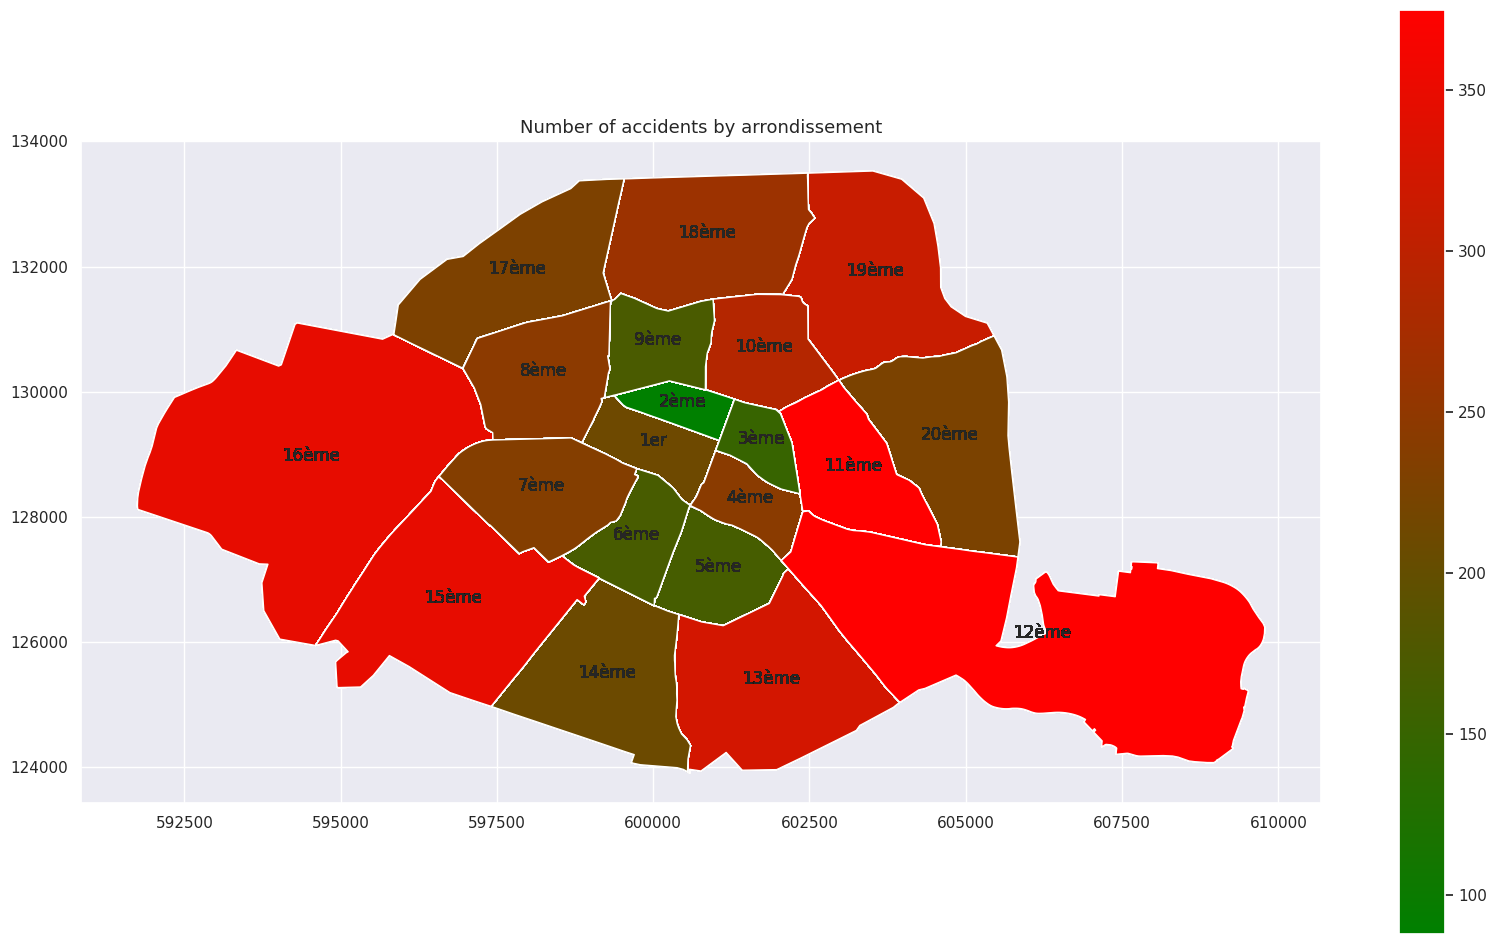

In [ ]:
import geoplot as gplt


# Read polygons of arrondissement
arrondis_gdf = gp.read_file("../data/arrondissements.geojson")
arrondis_gdf = arrondis_gdf.to_crs('epsg:27561')

# Drop cols with index_ suffix
#paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]

# Extract only accidents in paris (by name)
paris_accidents = accidents_by_department.loc[accidents_by_department['nom'] == 'Paris']

# Merge paris accidents with population data and remove cols with index_ (from merge result)
paris_accidents_by_pop2023 = paris_accidents.merge(population_filtered,on='nom')
paris_accidents_by_pop2023 = paris_accidents_by_pop2023.loc[:,~paris_accidents_by_pop2023.columns.str.startswith('index_')]

# Spatial join between arrondissement (polygon) and  accidents in paris (points), using 'intersects predicate
paris_arrondis_accidents_by_pop2023 = gp.sjoin(arrondis_gdf, paris_accidents_by_pop2023, predicate='intersects')

# Group by arronsidement names and merge with popsulation
population_by_arrondissement = paris_arrondis_accidents_by_pop2023.groupby('l_ar').size().reset_index(name='num_accidents')
paris_accidents_by_pop2023_arrondi = paris_arrondis_accidents_by_pop2023.merge(population_by_arrondissement,on='l_ar')

# Ploting result
ax = arrondis_gdf.plot(color="white",edgecolor="black",alpha=0.5, figsize=(20, 12))
paris_accidents_by_pop2023_arrondi.plot(ax=ax,column='num_accidents',cmap=region_intersect_cmap.reversed(),legend=True)

# Plot arrondissement labels based on polygons centroids
paris_accidents_by_pop2023_arrondi.apply(lambda x: ax.annotate(text= x['l_ar'].split(' ')[0], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_title('Number of accidents by arrondissement', fontsize=13);

## And plot data

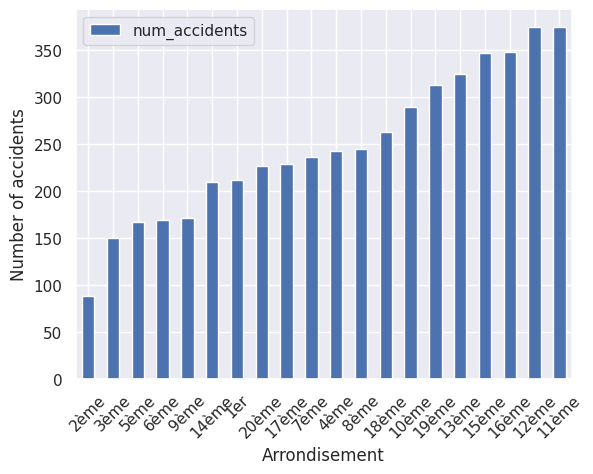

In [ ]:
# Order by accident
population_by_arrondissement_ordered = population_by_arrondissement.sort_values('num_accidents')
# Split X axis labels to extract first word
labels = list(population_by_arrondissement_ordered['l_ar'].apply(lambda x: x.split(' ')[0]))

# Define an axis with plot and its parameters
ax = population_by_arrondissement.sort_values('num_accidents').plot(kind='bar',x='l_ar',
                                                               xlabel="Arrondisement",
                                                               ylabel="Number of accidents")
ax.set_xticklabels(labels,rotation=45)

# Plot
plt.show()

It seems that the 11th and 12th arrondisement have the highest absolute number of bike accidents. But how about a relative number of accidents by zone ? We can make a grid to check if this is true. A great function can be found here : https://pygis.io/docs/e_summarize_vector.html

In [ ]:
import math
import numpy as np
from shapely.geometry import Polygon, box

def create_grid(feature, shape, side_length):
    '''Create a grid consisting of either rectangles or hexagons with a specified side length that covers the extent of input feature.'''

    # Slightly displace the minimum and maximum values of the feature extent by creating a buffer
    # This decreases likelihood that a feature will fall directly on a cell boundary (in between two cells)
    # Buffer is projection dependent (due to units)
    feature = feature.buffer(20)

    # Get extent of buffered input feature
    min_x, min_y, max_x, max_y = feature.total_bounds

    # Shape area
    area = 0


    # Create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Create grid of squares if specified
    if shape in ["square", "rectangle", "box"]:

        # Adapted from https://james-brennan.github.io/posts/fast_gridding_geopandas/
        # Create and iterate through list of x values that will define column positions with specified side length
        for x in np.arange(min_x - side_length, max_x + side_length, side_length):

            # Create and iterate through list of y values that will define row positions with specified side length
            for y in np.arange(min_y - side_length, max_y + side_length, side_length):

                # Create a box with specified side length and append to list
                cells_list.append(box(x, y, x + side_length, y + side_length))
        
        area = (side_length * side_length) / len(cells_list) 

    # Otherwise, create grid of hexagons
    elif shape == "hexagon":

        # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
        x_step = 1.5 * side_length

        # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
        # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
        y_step = math.sqrt(3) * side_length

        # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
        apothem = (math.sqrt(3) * side_length / 2)

        # Set column number
        column_number = 0

        # Create and iterate through list of x values that will define column positions with vertical displacement
        for x in np.arange(min_x, max_x + x_step, x_step):

            # Create and iterate through list of y values that will define column positions with horizontal displacement
            for y in np.arange(min_y, max_y + y_step, y_step):

                # Create hexagon with specified side length
                hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

                # Append hexagon to list
                cells_list.append(Polygon(hexagon))

            # Check if column number is even
            if column_number % 2 == 0:

                # If even, expand minimum and maximum y values by apothem value to vertically displace next row
                # Expand values so as to not miss any features near the feature extent
                min_y -= apothem
                max_y += apothem

            # Else, odd
            else:

                # Revert minimum and maximum y values back to original
                min_y += apothem
                max_y -= apothem

            # Increase column number by 1
            column_number += 1
        area  = (3 * math.sqrt(3) * pow(side_length,2)) / 2

    # Else, raise error
    else:
        raise Exception("Specify a rectangle or hexagon as the grid shape.")

    # Create grid from list of cells
    grid = gp.GeoDataFrame(cells_list, columns = ['geometry'], crs = "epsg:27561")

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid,area

### Create hexagons and regular grid cell

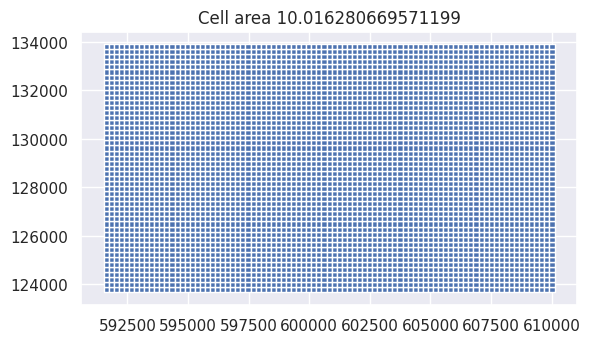

In [ ]:
# Create heaxagon
area_grid,area = create_grid(feature = paris_arrondis_accidents_by_pop2023, shape = 'rectangle', side_length = 209)
#cell_grid["cell_id"] = cell_grid.index + 1
#cell_grid.head(5)
area_grid.plot()
plt.title("Cell area " + str(area))
plt.show()

### Remove cells outside Paris

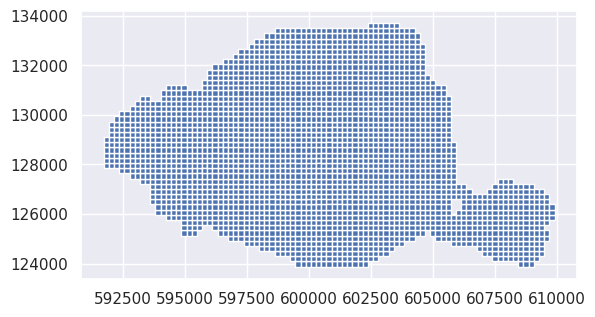

In [ ]:
area_grid_paris = gp.sjoin(area_grid, arrondis_gdf, how='inner', predicate='intersects')
# Remove fields from spatial join
area_grid_paris = area_grid_paris.loc[:,~area_grid_paris.columns.str.startswith('index_')]
area_grid_paris.reset_index(inplace=True)
area_grid_paris.plot()
plt.show()

### Later, we select regions and points in paris and aggreagate data using the cell layer

Dataframes have columns with name index ? : False


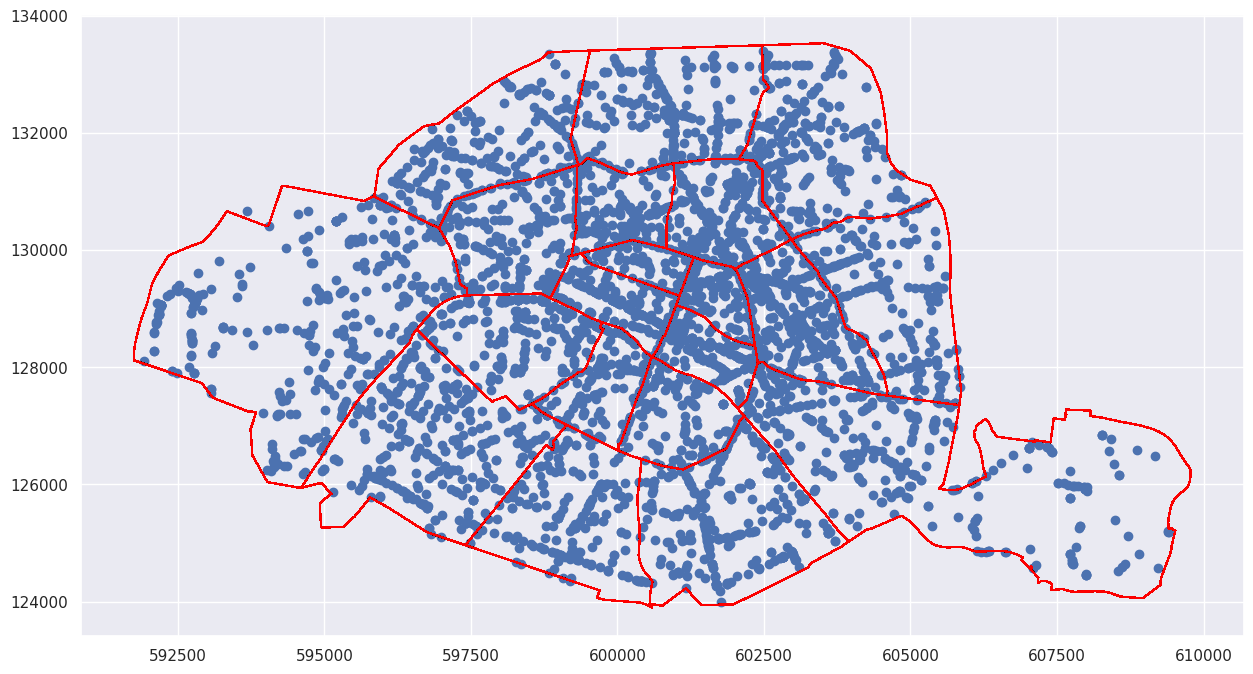

In [ ]:
## Remove index columns from previous merge operations, if necessary

paris_accidents = paris_accidents.loc[:,~paris_accidents.columns.str.startswith('index_')]
paris_accidents_by_pop2023_arrondi = paris_accidents_by_pop2023_arrondi.loc[:,~paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')]
print("Dataframes have columns with name index ? :", any(paris_accidents.columns.str.startswith('index_')) 
                                                      and any(paris_accidents_by_pop2023_arrondi.columns.str.startswith('index_')))


ax = paris_accidents.plot(figsize=(15, 10))
paris_accidents_by_pop2023_arrondi.plot(ax=ax,markersize=.1,color="None",edgecolor="red",legend=True)
plt.show()

In [ ]:
# Grab all dataset of accidents, within paris
#accidents_paris = gp.sjoin(accidents_by_department, paris_accidents_by_pop2023_arrondi, how='inner', predicate='within')
#accidents_paris = accidents_paris.loc[:,~accidents_paris.columns.str.startswith('index_')]
#accidents_paris.columns = accidents_paris.columns.str.rstrip("_left")
#accidents_paris.columns = accidents_paris.columns.str.rstrip("_right")

#paris_accidents.plot()
#plt.show()

In [ ]:
paris_accidents.head()

num_acc        date    an     mois      jour   hrmn dep    com  \
30208  201000062968  2010-10-03  2010  octobre  dimanche  18:45  75  75112   
30209  201000062968  2010-10-03  2010  octobre  dimanche  18:45  75  75112   
34199  201100046853  2011-05-06  2011      mai  vendredi  16:00  92  92051   
48001  201400045445  2014-07-27  2014  juillet  dimanche  20:05  94  94080   
52083  201500034568  2015-10-02  2015  octobre  vendredi  18:00  78  78117   

            lat     long  ...  obsm  choc  manv       vehiculeid  \
30208  48.83464  2.43893  ...   0.0   5.0  17.0  201000062968A01   
30209  48.83464  2.43893  ...   0.0   3.0   1.0  201000062968B01   
34199  48.87640  2.25041  ...   2.0   1.0  18.0  201100046853B01   
48001  48.84100  2.43288  ...   2.0   7.0   1.0  201400045445B01   
52083  48.85661  2.35222  ...   0.0   0.0   0.0  201500034568B01   

       typevehicules  manoeuvehicules  numvehicules  \
30208              1                1           1.0   
30209              1               17           1.0   
34199             30                1           1.0   
48001              7               10           1.0   
52083              7               15           1.0   

                            geometry  code    nom  
30208  POINT (607518.964 126023.362)    75  Paris  
30209  POINT (607518.964 126023.362)    75  Paris  
34199  POINT (593685.042 130665.746)    75  Paris  
48001  POINT (607073.936 126730.019)    75  Paris  
52083  POINT (601153.089 128461.520)    75  Paris  

[5 rows x 42 columns]

## Aggreate accidents by cell grid

In [ ]:
#######
# Perform spatial join, merging attribute table of wells point and that of the cell with which it intersects
# op = "intersects" also counts those that fall on a cell boundary (between two cells)
# op = "within" will not count those fall on a cell boundary

points_within = points_within.loc[:,~points_within.columns.str.startswith('index_')]

# Merging accidents data with grid data by spatial intersection boundary
grid_accidents = gp.sjoin(points_within, area_grid_paris, how='left', predicate='within')

# Add a field with constant value of 1
grid_accidents['num_acc_by_10m2'] = 1

# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = grid_accidents.dissolve(by="index_right", aggfunc="count")

# put this into cell
area_grid_paris.loc[dissolve.index, 'num_acc_by_10m2'] = dissolve["num_acc_by_10m2"].values

# Fill the NaN values (cells without any points) with 0 if we want to see
area_grid_paris['num_acc_by_10m2'] = area_grid_paris['num_acc_by_10m2'].fillna(0)
#cell_grid = cell_grid.within(paris_accidents_by_pop2023_arrondi)]


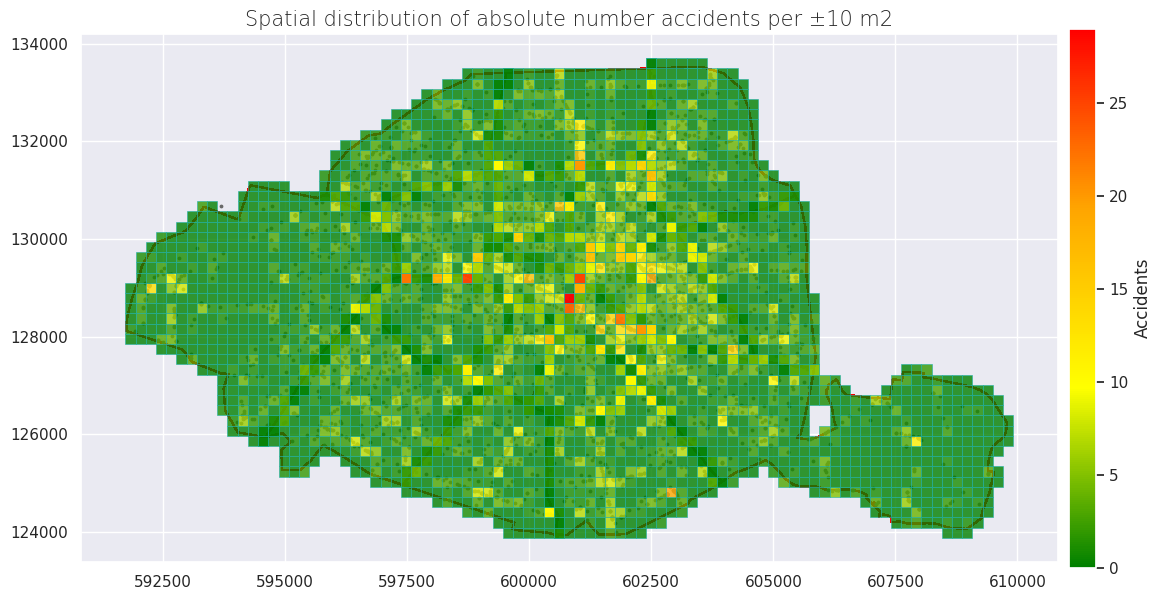

In [ ]:
# Plot data
legend_intervals = [int(area_grid_paris["num_acc_by_10m2"].min()),5,10,15,int(area_grid_paris["num_acc_by_10m2"].max())]

ax = paris_accidents_by_pop2023_arrondi.plot(markersize=.1, figsize=(15, 10),color="None",edgecolor="red",legend=True)
paris_accidents.plot(ax = ax,marker = 'o', color = 'dimgray', markersize = 3)
area_grid_paris.plot(ax = ax, column = "num_acc_by_10m2", 
                cmap=cmap,edgecolor="lightseagreen", linewidth = 0.5, alpha = 0.8,legend = True,
                legend_kwds={
                    "shrink":.70,
                    "format": "%g",
                    'label': "Accidents",
                    "pad": 0.01,
                    #"ticks" : legend_intervals
                })
# Set title
ax.set_title(f'Spatial distribution of absolute number accidents per ±{area:.0f} m2', fontdict = {'fontsize': '15', 'fontweight' : '3'})
plt.show()

### 14. Spatial weights and spatial correlation

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of similarity into a summary measure. Thus, the purpose of indicatoes of global spatial autocorrelation is to leverage the power of statistics to help us first summarize the spatial distribution of values present in a map, and second obtain a formal quantification of the departure from randomness. Spatial weights play a major role on spatial correlation

Spatial weights are mathematical structures used to represent spatial relationships. Many spatial analytics, such as spatial autocorrelation statistics and regionalization algorithms rely on spatial weights. Generally speaking, a spatial weight expresses the notion of a geographical relationship between locations `i` and `j`

To construct spatial weights (or a matrix weight), we will define a Spatial Lag, one of the most common and direct applications of spatial weights. We will use the Pysal library. The library implements several type of weighting functions according to the type of spatial weight (e.g. contiguity, distance, interactions, socioeconomic, networks, etc). Since we have a grid of polygons, our spatial weight is based on contiguity (common boundaries), which is in turn, based on neighborhood types according to figure below : 


<p align="center">
  <img src="../neighs.png" height="500"/>
</p>

For this post, we will use the Queen neighborhood :  



In [ ]:
import libpysal as lps
from libpysal.weights import Queen,Rook
import mapclassify as mc

# Transform row-standardized from data
#wq =  Queen.from_dataframe(area_grid_paris)

wq = lps.weights.KNN.from_dataframe(area_grid_paris, k=8)


# Row-standardization
w.transform = "R"

ModuleNotFoundError: No module named 'libpysal'

We can plot the contiguity weights

<Axes: >

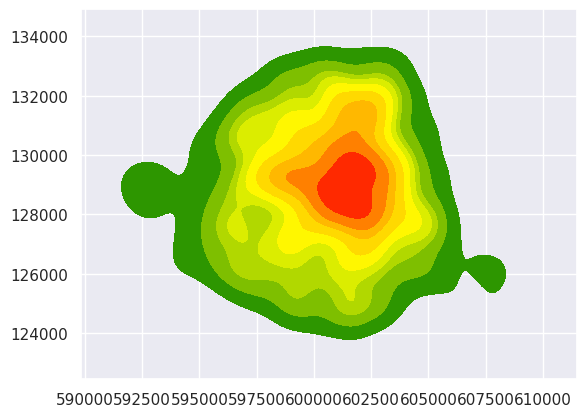

In [ ]:
sns.kdeplot(x=paris_accidents.geometry.x, y=paris_accidents.geometry.y, shade=True, cmap=cmap)

https://geographicdata.science/book/notebooks/04_spatial_weights.html

Next, we define a spatial lag, that is, to check if the number of accidents per area is an explanatory variable that tend to be be clustered geographically and thus, drive correlations

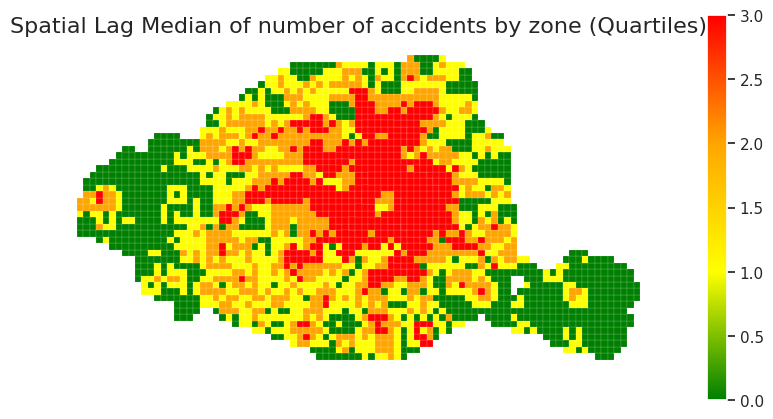

In [ ]:
# Drrive spaial lag 
y = area_grid_paris['num_acc_by_10m2']
ylag = lps.weights.lag_spatial(wq, y)

# Classify ussing quintilles
ylagq5 = mc.Quantiles(ylag, k=4)

f, ax = plt.subplots(1, figsize=(10, 5))

area_grid_paris.assign(cl=ylagq5.yb).plot(column='cl', k=5, cmap=cmap, linewidth=0.1, ax=ax, edgecolor='white', legend=True)

#cx.add_basemap(ax, crs=area_grid_paris.crs.to_string())
ax.axis('off')

plt.title("Spatial Lag Median of number of accidents by zone (Quartiles)", fontsize=16)

plt.show()

Of course, quantile maps for the spatial lag tends to enhance the impression of value similarity in space. It is, in effect, a local smoother

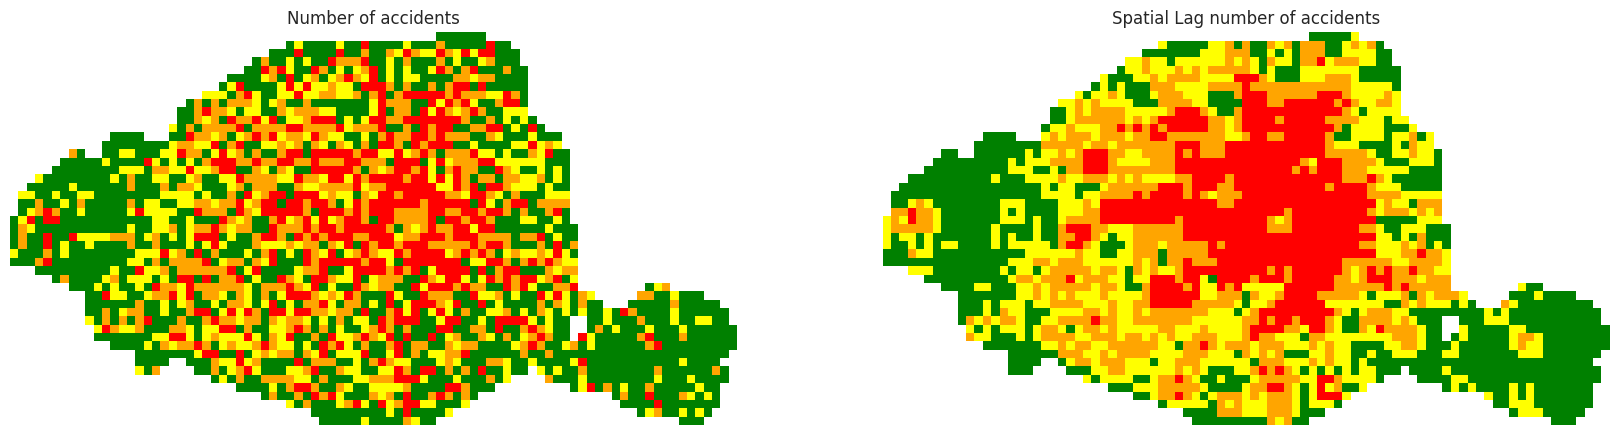

In [ ]:
area_grid_paris['lag_median_n_acc'] = ylag
f,ax = plt.subplots(1,2,figsize=(5.16*4,6))
area_grid_paris.plot(column='num_acc_by_10m2', ax=ax[0], edgecolor='none',
        scheme="quantiles",  k=4, cmap=cmap)
ax[0].axis(area_grid_paris.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Number of accidents")


area_grid_paris.plot(column='lag_median_n_acc', ax=ax[1], edgecolor='none',
        scheme='quantiles', cmap=cmap, k=4)
ax[1].axis(area_grid_paris.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag number of accidents")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

### 1. Global Spatial Autocorrelation for continous case


Moran's I is a test for global autocorrelation for a continuous attribute  developped by Patrick Alfred Pierce Moran. Spatial autocorrelation differs for one dimensional autocorrelation because spatial autocorrelation is more complex than one-dimensional autocorrelation because spatial correlation is multi-dimensional (i.e. 2 or 3 dimensions of space) and multi-directional (Wikipedia).

<br>
<p align="center">
  <img src="../polygon_patterns.png" width="600"/>
  <p align="center"> Source : ESRI </p>
</p>

Moran's I is a test for global autocorrelation for a continuous attribute. The value for the statistic needs to be interpreted against a reference distribution under the null of CSR. To perform such action, PySAL uses an approach random spatial permutations. More detail [here](https://pysal.org/notebooks/explore/esda/Spatial_Autocorrelation_for_Areal_Unit_Data.html)
We will start using the library `esda`, the acronym for Exploratory Spatial Data Analysis in PySAL. The library contains usefull wrappers to apply methods for testing for global and local autocorrelation in areal unit data.

Text(0.5, 0, "Moran's I")

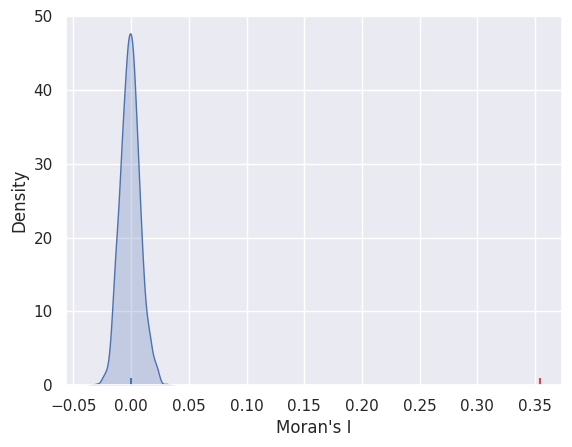

In [ ]:
import esda 
import seaborn as sbn

np.random.seed(12345)
mi = esda.moran.Moran(y, wq)

sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")



In [ ]:
# Build a data frame for sumary
moran_summary = pd.DataFrame(data={'Moran\'s Index': [mi.I],'Expected moran\'s index': [mi.EI],'Variance': [mi.VI_norm],'z score': [mi.z_norm],'p score': [mi.p_norm]})
display(moran_summary)

Moran's Index  Expected moran's index  Variance    z score  p score
0       0.353855               -0.000333  0.000073  41.360326      0.0

The results shows that our assumption that the zones with gravitity of accidents is clustered by accidents by zone. The `p` value is 0 and the Moran's index is positive, which indicates a strong clustering pattern. If the Moran's index was negative, this would indicate a dispersed pattern. So we failed the null hypothesis that the pattern is random.

The observed value (0.35) is statistically significant:

### 16. Local spatial correlation

One of the most classic approaches for local spatial correlation is Moran's I test. The approch allow us to indentify Hot spots, Cold Spots, and Spatial Outliers using Moran’s I (citation). Morain's I is frequently used as the tool to measure adns test spatial autocorrelation. If observation values are similar, Moran’s I value becomes positive (+), and, if they are not similar, the value becomes negative (-). When we plot a Moran's scatterplot :

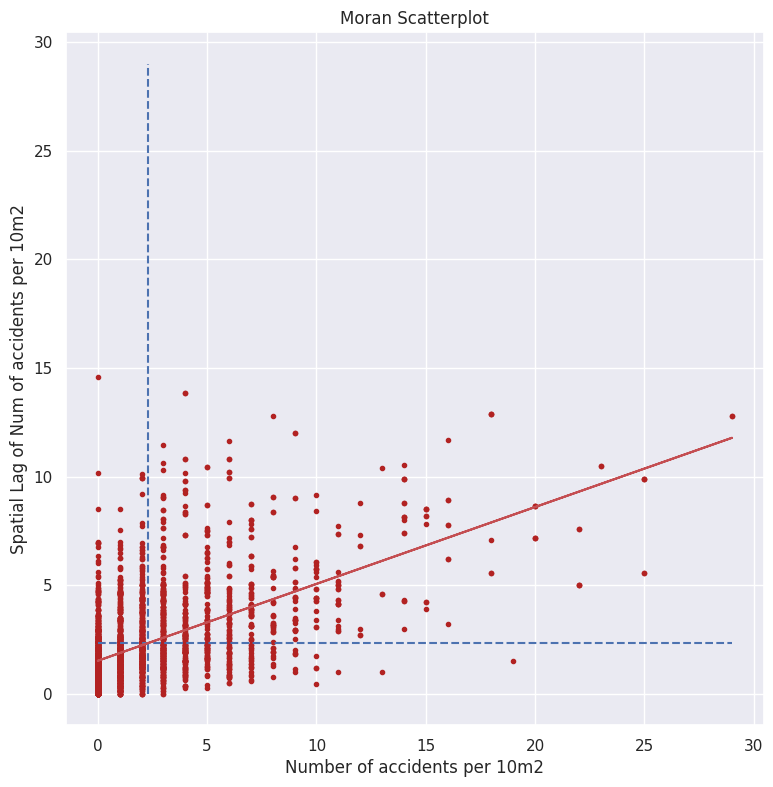

In [ ]:
wq.transform = 'r'
lag_acc = lps.weights.lag_spatial(wq, area_grid_paris['num_acc_by_10m2'])
accs = area_grid_paris['num_acc_by_10m2']
b, a = np.polyfit(accs, lag_acc, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(accs, lag_acc, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(accs.mean(), accs.min(), accs.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(accs.mean(), accs.min(), accs.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(accs, a + b*accs, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Num of accidents per 10m2')
plt.xlabel('Number of accidents per 10m2')
plt.show()

We split our accidents in 5 categories : Not significant(0), which do not influence in the spatial autocorrelation , Hot Spot(1) for positive values of spatial autocorrelation, Cold Spot(2) for negative values of spatial autocorrelation, Low-low(3), and Hi-low(4). Hot spot areas (High-High) are areas where the number of accidents are high and it is similar to those of neighboring areas. Cold spot areas (Low-Low) are the areas where the number of accidents are low, and it is similar to those of neighboring areas. Similarly, Hi-low areas are areas where the number of accidents is high, but its neighbors' number of accidents are low, and vice-versa for Low-hi areas.

Finally ,we plot the spots

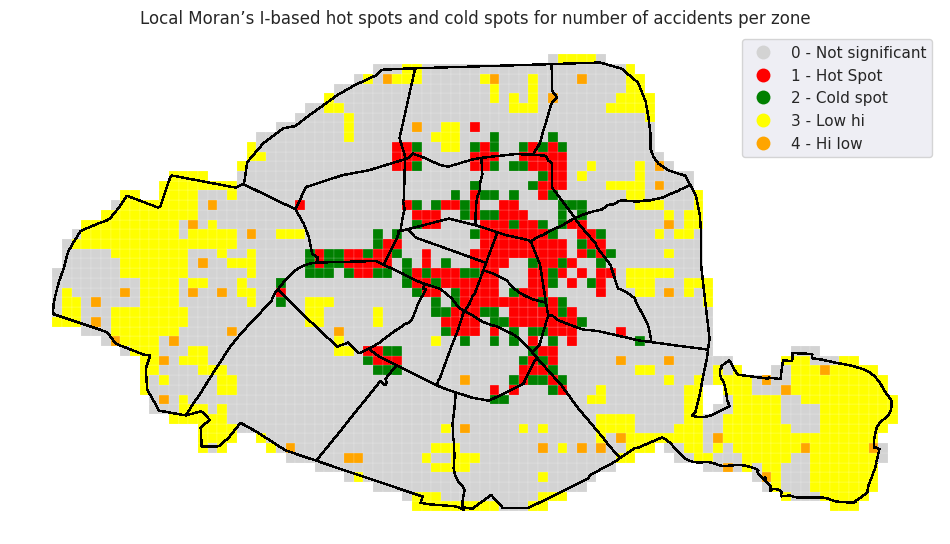

In [ ]:
from esda.moran import Moran_Local

mil = Moran_Local(y, wq)

# Define a sigmoid
sig = 1 * (mil.p_sim < 0.05)
# Define classes
hotspot = 1 * (sig * mil.q==1) #hi-hi
coldspot = 3 * (sig * mil.q==3) #low-low
doughnut = 2 * (sig * mil.q==2) #low-hi
diamond = 4 * (sig * mil.q==4) # #hi-low
# All spots
spots = hotspot + coldspot + doughnut + diamond

spot_labels = [ '0 - Not significant', '1 - Hot Spot', '2 - Cold spot', '3 - Low hi', '4 - Hi low']
labels = [spot_labels[i] for i in spots]

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'green', 'yellow', 'orange'])
f, ax = plt.subplots(1, figsize=(12, 9))
area_grid_paris.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
paris_accidents_by_pop2023_arrondi.plot(ax=ax,markersize=.1,color="None",edgecolor="black",legend=True)
ax.set_axis_off()
plt.title("Local Moran’s I-based hot spots and cold spots for number of accidents per zone")
plt.show()

Altought we will not perform other tests for non-normality and heteroscedasticity we can easilly check if the dataset is suitable to apply a spatial regression model to estimate and calculate real number of accidents by area. Using Pysal is very easy. First, we hot-encode time variables, such as days of week, day, month ,year, hour and minute. The is a nice post [here](https://mikulskibartosz.name/time-in-machine-learning) explaning how we shoud consider the hot encoding for days of week, for instance. Since the order of the days is not important, we proceed as following :


In [ ]:
# Make a copy
paris_accidents_test = paris_accidents.copy()


# Make onehot encoding on jour and mois column as int, since the default is boolean type 
one_hot_jour = pd.get_dummies(paris_accidents_test['jour'],dtype=int)


# Extract year month and day (but use only month and day)
year_month_day = paris_accidents_test["date"].apply(lambda x: pd.Series(str(x).split("-")))

# Drop hot encoded cols and date
paris_accidents_test = paris_accidents_test.drop('jour',axis = 1)
paris_accidents_test = paris_accidents_test.drop('date',axis = 1)
# Split str hour:min into two columns and convert to numeric
paris_accidents_test[['hour', 'min']] = paris_accidents_test["hrmn"].apply(lambda x: pd.Series(str(x).split(":")))
paris_accidents_test[['hour', 'min']] = paris_accidents_test[['hour', 'min']].apply(pd.to_numeric)

# Join the hotencoded columns to the dataframe
paris_accidents_test = paris_accidents_test.join(one_hot_jour)
paris_accidents_test["month"] = year_month_day[1].astype('int32')
paris_accidents_test["day"] = year_month_day[2].astype('int32')


# Check
predictors = ["hour","min","month","day","lundi","mardi","mercredi","jeudi","vendredi","samedi","dimanche"]
matrix = paris_accidents_test[["geometry"] + predictors].dropna()
matrix


geometry  hour   min  month  day  lundi  mardi  \
30208  POINT (607518.964 126023.362)    18  45.0     10    3      0      0   
30209  POINT (607518.964 126023.362)    18  45.0     10    3      0      0   
34199  POINT (593685.042 130665.746)    16   0.0      5    6      0      0   
48001  POINT (607073.936 126730.019)    20   5.0      7   27      0      0   
52083  POINT (601153.089 128461.520)    18   0.0     10    2      0      0   
...                              ...   ...   ...    ...  ...    ...    ...   
74744  POINT (605079.478 127136.395)    16  15.0      1    6      0      0   
74746  POINT (601395.226 129104.982)    17  35.0      1    4      1      0   
74748  POINT (603267.313 131250.488)    18  25.0      1    4      1      0   
74749  POINT (599872.532 129390.386)    19  40.0      1    4      1      0   
74756  POINT (602206.940 130718.654)    15  40.0      1    2      0      0   

       mercredi  jeudi  vendredi  samedi  dimanche  
30208         0      0         0       0         1  
30209         0      0         0       0         1  
34199         0      0         1       0         0  
48001         0      0         0       0         1  
52083         0      0         1       0         0  
...         ...    ...       ...     ...       ...  
74744         1      0         0       0         0  
74746         0      0         0       0         0  
74748         0      0         0       0         0  
74749         0      0         0       0         0  
74756         0      0         0       1         0  

[4968 rows x 12 columns]

In [ ]:
#matrix['lat'] = matrix.apply(lambda row: row.geometry.x,axis = 1)
#matrix['long'] = matrix.apply(lambda row: row.geometry.y,axis = 1)
#matrix

In [ ]:
ax = gdf.plot(edgecolor='grey', facecolor='w')
f,ax = w_rook.plot(gdf, ax=ax,
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off(

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:

paris_accidents_test = paris_accidents_test.dropna()
m1 = lps.spreg.OLS(
            # Dependent variable
            paris_accidents_test[['grav']].values ,
            # Independet variable
            paris_accidents_test[variable_names].values,
            # Dependent variable name
            name_y = "grav",
            # Indepent variable name
            name_x = predictors
            )

print(m1.summary)


AttributeError: module 'libpysal' has no attribute 'spreg'

In [ ]:
from pysal.lib import weights
import seaborn as sns
knn = weights.KNN.from_dataframe(accidents_paris_test, k=7)

lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = sns.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$");

ModuleNotFoundError: No module named 'pysal'

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x0000025EADA56570>

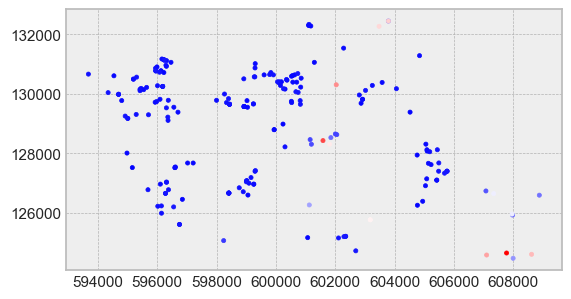

In [ ]:
import contextily as cx
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.1
# Add `error_clusters` and `local_I` columns
ax = (
    accidents_paris_test.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
cx.add_basemap(ax, crs=accidents_paris_test.crs)
# Remove axes
ax.set_axis_off();

## 17. Interpolation methods

Interpolation is a statistical method with calculate values for cells in a raster from a limited number of sample data points. It can be used to predict unknown values for any geographic point data, such as elevation, rainfall, chemical concentrations, noise levels, and so on. In our case, we want to predict the mumber of accidents per cel where there are no occurences of bicycle accidents. There is a plethora of spatial interpolation methods. A non-exaustive list include :

* IDW
* Kriging
* Natural neighbour
* Spline

In this excercise, we wil apply Spline, Kriging, and Natural neighbour interpolation methods to our data set and compare the results

To introduce interpolation, lets apply the Spline interpolation method to our data. We define some functions to create data to plot, and a plot function. The `create_plot_data` takes some data as input, takes 10 random observations from the input data, and generates data to be used in a plot function

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

def f(x):
    """Function to be approximated by polynomial interpolation."""
    return x * np.sin(x)

def create_plot_data(data) :

    # Calculate the x_axis values based on real data
    x_plot = np.linspace(min(data), max(data), len(data))

    # To make it interesting, we only give a small subset of points to train on.
    rng = np.random.RandomState(0)
    x_train = np.sort(rng.choice(data, size=10, replace=False)) # Generates a random sample of 10 observations from the real data
    y_train = f(x_train) # Aplly a sin function to the train data and get values 

    # create 2D-array versions of these arrays to feed to transformers
    x_train_2d = x_train[:, np.newaxis]
    x_plot_2d = x_plot[:, np.newaxis]

    return x_plot,x_train,x_plot_2d,x_train_2d, y_train

# Plot

def plot_interpolations(x_plot,x_train,x_plot_2d,x_train_2d, y_train):
    lw = 2
    fig, ax = plt.subplots()
    ax.set_prop_cycle(
        color=["black", "teal", "yellowgreen", "gold", "darkorange", "tomato"]
    )
    ax.plot(x_plot, f(x_plot), linewidth=lw, label="ground truth")

    # plot training points
    ax.scatter(x_train, y_train, label="training points")

    # polynomial features
    for degree in [3, 4, 5]:
        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
        model.fit(x_train_2d, y_train)
        y_plot = model.predict(x_plot_2d)
        ax.plot(x_plot, y_plot, label=f"degree {degree}")

    # B-spline with 4 + 3 - 1 = 6 basis functions
    model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
    model.fit(x_train_2d, y_train)

    y_plot = model.predict(x_plot_2d)
    ax.plot(x_plot, y_plot, label="B-spline")
    ax.legend(loc="lower center")
    ax.set_ylim(-max(x_plot), max(x_plot))
    plt.show()

Next, we send the data to plot and plot the interpolation functions

c:\Projects\venvs\work2\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.11851e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


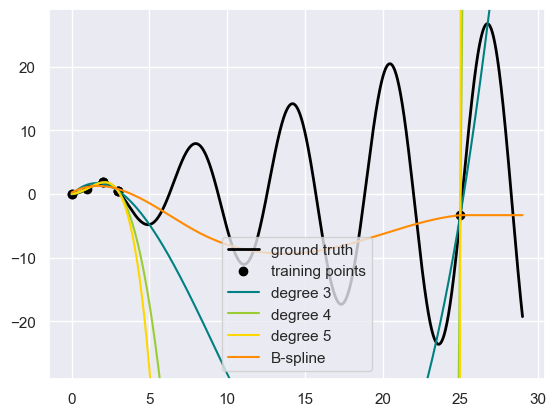

In [ ]:
# Get the real data
samples = area_grid_paris["n_acc"].to_list()
# Create data for plots
x_plot,x_train,x_plot_2d,x_train_2d, y_train = create_plot_data(samples)
plot_interpolations (x_plot,x_train,x_plot_2d,x_train_2d, y_train)


Splines make a good job on fitting well the data, and provide the same time, some paramenters to control extrapolation. However, seasonal effects (like vacation, for example) may cut an expected periodic continuation of the underlying signal. In our case, the signal is the number of accidents. And for cases that are affected by seasonal effects, periodic splines could be used. Let's see the application of periodic splines to our data

In [ ]:
def g(x):
    """Function to be approximated by periodic spline interpolation."""
    return np.sin(x) - 0.7 * np.cos(x * 3)

def plot_periodic_spline(x_train,x_train_2d, y_train) :
    
    # Get training data by applying the g function to the training data
    y_train = g(x_train)

    # Extend the test data into the future:
    x_plot_ext = np.linspace(min(samples), max(samples) + 10, len(samples) + 100)
    X_plot_ext = x_plot_ext[:, np.newaxis]

    lw = 2
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=["black", "tomato", "teal"])
    ax.plot(x_plot_ext, g(x_plot_ext), linewidth=lw, label="ground truth")
    ax.scatter(x_train, y_train, label="training points")

    # A list of (transformer, label)
    for transformer, label in [
        (SplineTransformer(degree=3, n_knots=10), "spline"),
        (
            SplineTransformer(
                degree=3,
                knots=np.linspace(0, 2 * np.pi, 10)[:, None],
                extrapolation="periodic",
            ),
            "periodic spline",
        ),
    ]:
        model = make_pipeline(transformer, Ridge(alpha=1e-3))
        model.fit(x_train_2d, y_train)
        y_plot_ext = model.predict(X_plot_ext)
        ax.plot(x_plot_ext, y_plot_ext, label=label)

    ax.legend()

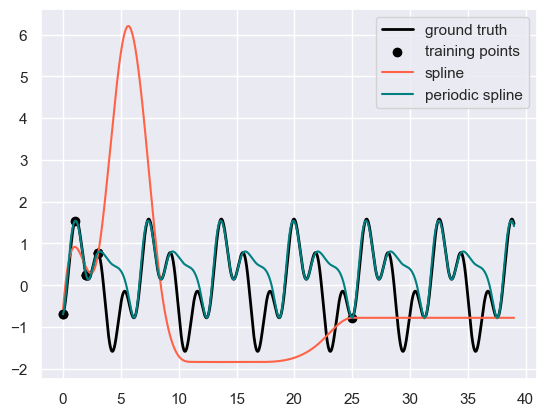

In [ ]:
plot_periodic_spline (x_train,x_train_2d, y_train)

Periodic works well with the data, specially if we consider that we do not have negative values. One thing to consider, tough, is how well distributed our data is. Interpolation methods can benefit for data normalization, but in certain cases, it could also compromise the model's performance. If we plot the distribution of the data, we can see that the data is left-skewed and not normalized : 

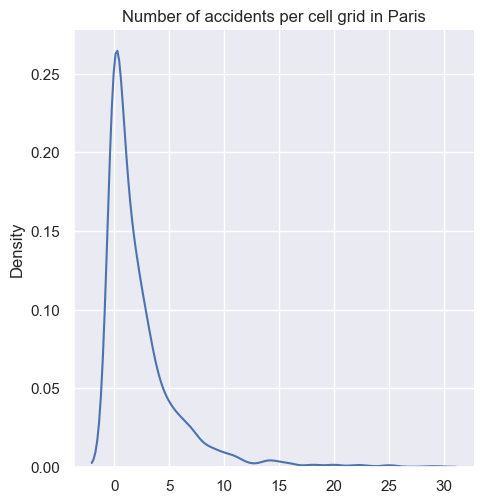

In [ ]:

sns.displot(samples,kind="kde")
plt.title("Number of accidents per cell grid in Paris")
plt.show()

### Define helper functions for raster interpolration

We will return to this point later, to check if the normalizing the data may positively affect the interpolation performance. For now, we must transform our data to raster format if we wish to apply interpolation approaches to the data. Transforming our grid to raster should give us the following result :


In [ ]:
import rasterio
from rasterio import features,transform
from rasterio.plot import show
from osgeo import gdal
import time
from shutil import copy2
import os
from rasterio.mask import mask
from affine import Affine
import rasterio

def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Define a temp raster file name to avoid overwriting and permission issues using rasterio
    temp = f'temp_{int(time.time())}.tif'

    # Export array as raster
    with rasterio.open(temp,mode = "w", driver = "GTiff", height = Z.shape[0],width = Z.shape[1],
                       count = 1, dtype = Z.dtype, crs = proj, transform = transform) as new_dataset:
        new_dataset.write(Z, 1)

    copy2(temp,filename)
    os.remove(temp)


def make_raster_from_feature(feature, feature_field_value, raster_out:str="./raster_out.tif") :
    # Get a generator of geom, value pairs 
    shapes = ((geom,value) for geom, value in zip(feature["geometry"], feature[feature_field_value]))

    # Getting meta data from vector file
    bbox = feature.total_bounds
    xmin, ymin, xmax, ymax = bbox
    res = 100 # desired resolution
    w = (xmax - xmin) // res 
    h = (ymax - ymin) // res

    out_meta = {
        "driver": "GTiff",
        "dtype": "float32",
        "height": h,
        "width": w,
        "count": 1,
        "crs": feature.crs,
        "transform": transform.from_bounds(xmin, ymin, xmax, ymax, w, h),
        "compress": 'lzw',
    }

    # Define a temp raster file name to avoid overwriting and permission issues using rasterio
    temp = f'temp_{int(time.time())}.tif'

    print(shapes)

    # Save to temp file using metadata, copy to output raster and remove temporary file
    with rasterio.open(temp, 'w+', **out_meta) as out:
        out_image, out_transform=mask(out,feature.geometry,filled=True,crop=True)
        out_meta.update({
            "transform":out_transform
        })
        #out_arr = out.read(1)
        burned = features.rasterize(shapes=shapes, fill=0, out=out_image, transform=out.transform)
        out.write(out_image)

    copy2(temp,raster_out)
    os.remove(temp)



#### Define train test split and plot

Text(0.5, 1.0, 'Paris accidents locations')

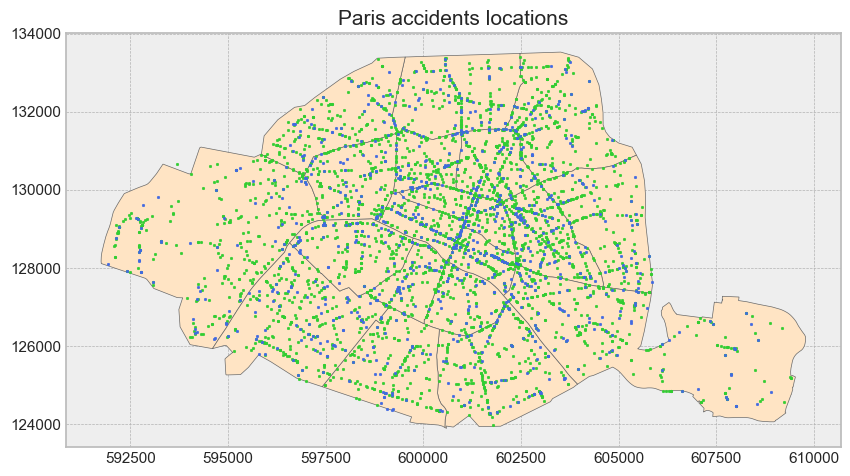

In [ ]:
from sklearn.model_selection import train_test_split
from shapely import Point

# Trying with accidents_paris (and gravity) instead of area_grid_paris(and n_acc)
accidents_paris = gp.sjoin(accidents_by_department, paris, predicate='within')

# Create list of XY coordinate pairs
coords_acc = [list(xy) for xy in zip(accidents_paris["geometry"].x, accidents_paris["geometry"].y)]

# Get list of number of accidents 
grav_accidents = list(accidents_paris["grav"])

# Split accidents data into testing and training sets
coords_accidents_train, coords_accidents_test, grav_accidents_train, grav_accidents_test = train_test_split(coords_acc, grav_accidents, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
acc_train_gdf = gp.GeoDataFrame(geometry = [Point(g[0], g[1]) for g in coords_accidents_train], crs = accidents_paris.crs)
acc_train_gdf["current_value"] = grav_accidents_train
acc_test_gdf = gp.GeoDataFrame(geometry = [Point(g[0], g[1]) for g in coords_accidents_test], crs = accidents_paris.crs)
acc_test_gdf["current_value"] = grav_accidents_test

# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
arrondis_gdf.plot(ax = ax, color = 'bisque', edgecolor = 'dimgray')
acc_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
acc_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('Paris accidents locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})


### KNN definition and in-sample performance

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
# Set number of neighbors to look for
neighbors = 8

# Initialize KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors = neighbors, weights = "distance")

# Fit regressor to data
knn_regressor.fit(coords_accidents_train, grav_accidents_train)

# Generate in-sample R^2
in_r_squared_knn = knn_regressor.score(coords_accidents_train, grav_accidents_train)
print("KNN in-sample r-squared: {}".format(round(in_r_squared_knn, 2)))


KNN in-sample r-squared: 0.88


### KNN test and out of sample performance

KNN out-of-sample r-squared: -0.52

Attribute Table: Testing Set Interpolated Values - KNN Method


coordinates  current  predicted
0  [596910.9646754247, 130763.05186663037]        4   3.708686
1  [602079.3717217844, 128162.76190901283]        4   1.891101
2  [597885.8295898578, 129697.42257466805]        4   4.000000
3   [599700.9576105741, 128671.5911467716]        4   4.000000
4  [596712.0184101565, 131686.13690084577]        3   3.495496
5  [601352.7339794823, 128215.80859766876]        4   3.798221

<generator object make_raster_from_feature.<locals>.<genexpr> at 0x0000025F4D61B4C0>


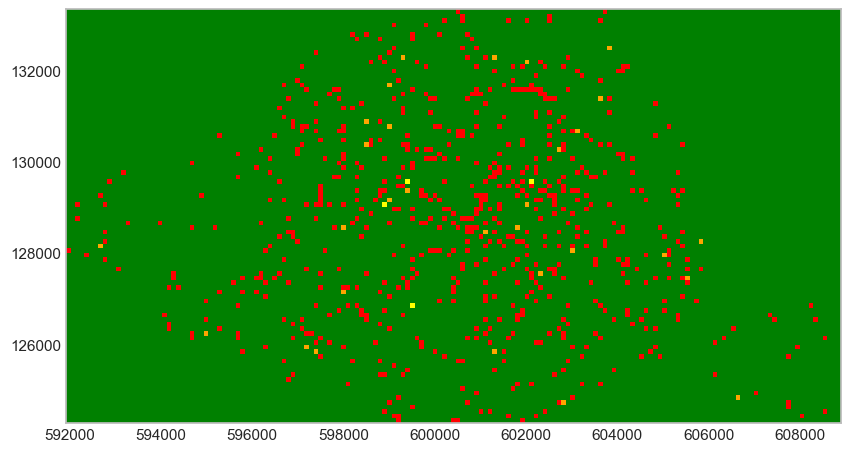

In [ ]:
from matplotlib.colors import Normalize
# Generate out-of-sample R^2
out_r_squared_knn = knn_regressor.score(coords_accidents_test, grav_accidents_test)
print("KNN out-of-sample r-squared: {}".format(round(out_r_squared_knn, 2)))

# Predict values for testing dataset
coords_accidents_test_predict_knn = knn_regressor.predict(coords_accidents_test)

# Create dictionary holding the actual and predicted values
predict_dict_knn = {"coordinates": coords_accidents_test, "current": grav_accidents_test, "predicted": coords_accidents_test_predict_knn}

# Create dataframe from dictionary
predict_df_knn = pd.DataFrame(predict_dict_knn)

# Display attribute table
print("\nAttribute Table: Testing Set Interpolated Values - KNN Method")
display(predict_df_knn.head(6))

# Recreate the geodataframe
predict_df_knn['x'] = predict_df_knn.coordinates.apply(lambda coord: coord[0])
predict_df_knn['y'] = predict_df_knn.coordinates.apply(lambda coord: coord[1])

gdf_predicted_knn = gp.GeoDataFrame(
    predict_df_knn, geometry=gp.points_from_xy(predict_df_knn.x, predict_df_knn.y)
)
# Make knn raster
make_raster_from_feature(gdf_predicted_knn,"current","./accidents_knn.tif")

#Open created raster
rasterized_accidents_in_paris = rasterio.open("./accidents_knn.tif")

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
norm = Normalize(vmin=min(predict_df_knn.predicted), vmax=max(predict_df_knn.predicted))
show(rasterized_accidents_in_paris, ax = ax,cmap=cmap,norm=norm)
plt.grid(None)
plt.show()

### Kriging

#### Generate oridinary kriging object, evaluate the method on grid and export raster

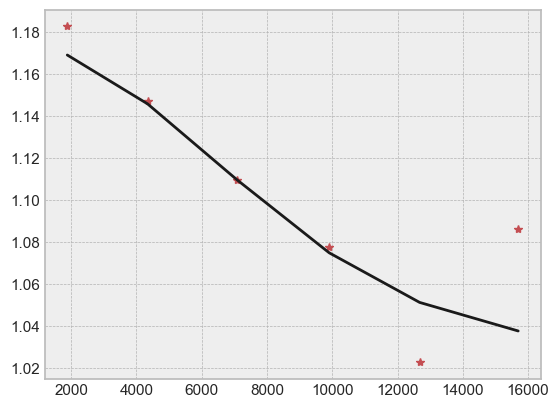

[[3.9359589295852286 3.9249413260272923 3.9138536731698235 ...
  4.1198477487862855 4.126195544362124 4.132423792744019]
 [3.938356635018191 3.9273352936070327 3.91624427159823 ...
  4.113013823953554 4.119353959037548 4.125577031842935]
 [3.9407120043827133 3.929687361651104 3.918593422852075 ...
  4.106113342362173 4.112445300410865 4.118662702912134]
 ...
 [3.29480455140502 3.2874553946635103 3.2803108901328546 ...
  2.9303884889295557 2.9294523469237346 2.928802462384798]
 [3.289295493583415 3.2819712496900717 3.2748526849142072 ...
  2.9308020674574724 2.9298349753936788 2.929153840425461]
 [3.2838301941022348 3.2765308819387045 3.2694382565624545 ...
  2.9312907468568192 2.9302930857126626 2.929581054671965]]


In [ ]:
from pykrige import OrdinaryKriging


# Get X and Y coordinates of accidents grid points
longs = accidents_paris['geometry'].x
lats = accidents_paris['geometry'].y

# Generate ordinary kriging object
OK = OrdinaryKriging(
    np.array(longs),
    np.array(lats),
    np.array(grav_accidents),
    variogram_model="gaussian", 
    variogram_parameters={'sill': 1.030, 
                            'range': 16000, 
                            'nugget': 1.175},
    exact_values=False,
    enable_plotting=True
)

# Generate the grids for longitude and lantitude, the number of bins is 100¶

grid_coord_longs = np.linspace(min(longs), max(longs), 201)
grid_coord_lats = np.linspace(min(lats), max(lats), 201)

# Evaluate the method on grid
z, sigma_squared_p_krig = OK.execute("grid", grid_coord_longs, grid_coord_lats)



# Get minimum and maximum coordinate values of rainfall training points
min_x_acc, min_y_acc, max_x_acc, max_y_acc = arrondis_gdf.total_bounds

# Export raster
export_kde_raster(Z = z, XX = grid_coord_longs, YY = grid_coord_lats,
                  min_x = min_x_acc, max_x = max_x_acc, min_y = min_y_acc, max_y = max_y_acc,
                  proj = arrondis_gdf.crs, filename = "./accidents_kriging.tif")

print (z)

#### User krigging results and plot result

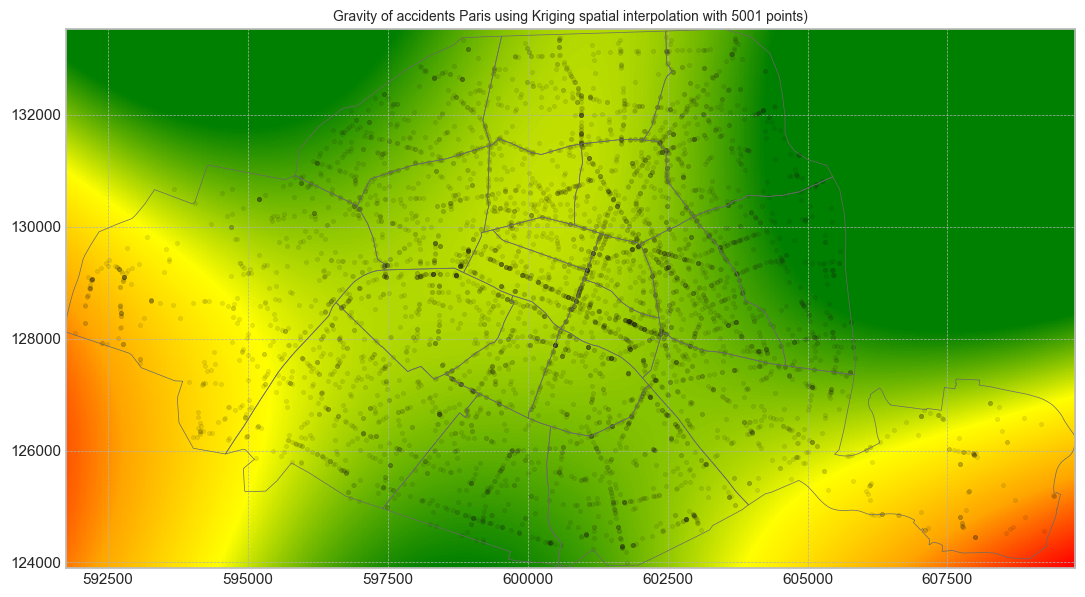

In [ ]:
import matplotlib as mpl

raster_pk = rasterio.open("./accidents_kriging.tif")

# Mask (not working over a masked raster)
out_image_pk, out_transform_pk = rasterio.mask.mask(raster_pk, arrondis_gdf.geometry.values, crop = True,filled=True)

# Stylize plots
#plt.style.use('bmh')

#export_kde_raster(out_image_pk[0],XX = XX_pk_krig, YY = YY_pk_krig,
#                  min_x = min_x_acc, max_x = max_x_acc, min_y = min_y_acc, max_y = max_y_acc,
#                  proj = arrondis_gdf.crs, filename = "./accidents_kriging_crop.tif")
#norm
norm = mpl.colors.Normalize(vmin=np.min(out_image_pk[0]), vmax=np.max(out_image_pk[0]))



fig, ax = plt.subplots(1, figsize=(15,7))


norm = mpl.colors.Normalize(vmin=min(z[0]), vmax=max(z[0]))

# Plot krig results
cax = plt.imshow(z,extent=(min_x_acc, max_x_acc,min_y_acc, max_y_acc),origin='lower',cmap=cmap,norm=norm)

# Plot accidents
plt.scatter(longs,lats,c='k',marker = '.',alpha=0.1)

# Define legend based on krig results
#cbar = plt.colorbar(ax)

# Plot arrondissements
arrondis_gdf.plot(ax = ax, color = 'none', edgecolor = 'dimgray')

# Plot
npts = len(np.array(longs))
plt.title('Gravity of accidents Paris using Kriging spatial interpolation with %d points)' % npts,fontsize = 10)
#ax.set_facecolor("yellow")

# # Add a legend for labels
#legend_labels = {"green": "Low", 
#                 "yellow": "Medium", 
#                 "orange": "High",
#                 "red": "Very High"}

#patches = [Patch(color=color, label=label) for color, label in legend_labels.items()]

#ax.legend(handles=patches, bbox_to_anchor=(1, 1),facecolor="white")

plt.show()




### Mask the data

### Mesuring Kriging performance

In [ ]:
from sklearn.metrics import r2_score

# # Open raster
raster_pk = rasterio.open("./accidents_kriging.tif")

# Create polygon with extent of raster
poly_shapely = box(*raster_pk.bounds)

# Create a dictionary with needed attributes and required geometry column
attributes_df = {'Attribute': ['name1'], 'geometry': poly_shapely}


# # Create copy of test dataset
acc_test_gdf_pk_krig = acc_test_gdf.copy()

# Convert shapely object to a GeoDataFrame
raster_pk_extent = gp.GeoDataFrame(attributes_df, geometry = 'geometry', crs = accidents_paris.crs)

# # Subset the GeoDataFrame by checking which test points are within the raster extent polygon
# # If a test point is beyond the extent of training points dataset, the kriging output may not cover that test point
acc_test_gdf_pk_krig = acc_test_gdf_pk_krig[acc_test_gdf_pk_krig.within(raster_pk_extent.geometry.values[0])]

# # Create list of XY coordinate pairs for the test points that fall within raster extent polygon
coords_acc_test_pk_krig = [list(xy) for xy in zip(acc_test_gdf_pk_krig["geometry"].x, acc_test_gdf_pk_krig["geometry"].y)]

# # Extract raster value at each test point and add the values to the GeoDataFrame
acc_test_gdf_pk_krig["predicted"] = [x[0] for x in raster_pk.sample(coords_acc_test_pk_krig)]

# # Generate out-of-sample R^2
out_r_squared_tp = r2_score(acc_test_gdf_pk_krig["current_value"], acc_test_gdf_pk_krig["predicted"])
print("PyKrige Kriging out-of-sample r-squared: {}".format(round(out_r_squared_tp, 7)))

# # Display attribute table
print("\nAttribute Table: Random Points Interpolated Values - PyKrige Kriging Method")
display(acc_test_gdf_pk_krig.head(10))

PyKrige Kriging out-of-sample r-squared: -0.0003366

Attribute Table: Random Points Interpolated Values - PyKrige Kriging Method


geometry  current_value  predicted
0  POINT (596910.965 130763.052)            4.0   3.459282
1  POINT (602079.372 128162.762)            4.0   3.495276
2  POINT (597885.830 129697.423)            4.0   3.518883
3  POINT (599700.958 128671.591)            4.0   3.535609
4  POINT (596712.018 131686.137)            3.0   3.392131
5  POINT (601352.734 128215.809)            4.0   3.511505
6  POINT (596614.104 127538.398)            4.0   3.545652
7  POINT (601276.502 128496.463)            4.0   3.517633
8  POINT (602654.822 127246.817)            1.0   3.482730
9  POINT (603594.414 131819.703)            4.0   3.402912

#### IDW

#### Define necessary functions

In [ ]:
def distance_matrix(x0, y0, x1, y1):
    """ Make a distance matrix between pairwise observations.
    Note: from <http://stackoverflow.com/questions/1871536> 
    """
    
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])
    
    # calculate hypotenuse
    return np.hypot(d0, d1)
def simple_idw(x, y, z, xi, yi, power=1):
    """ Simple inverse distance weighted (IDW) interpolation 
    Weights are proportional to the inverse of the distance, so as the distance
    increases, the weights decrease rapidly.
    The rate at which the weights decrease is dependent on the value of power.
    As power increases, the weights for distant points decrease rapidly.
    """
    
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0/(dist+1e-12)**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    return np.dot(weights.T, z)
def plot(x,y,z,grid):
    """ Plot the input points and the result """
    plt.figure(figsize=(15,7))
    plt.imshow(grid, extent=(min(x), max(x), max(y), min(y)), cmap=cmap, interpolation='gaussian')
    #plt.scatter(x,y,c=z, cmap='rainbow', edgecolors='black')
    plt.colorbar()

#### Test IDW

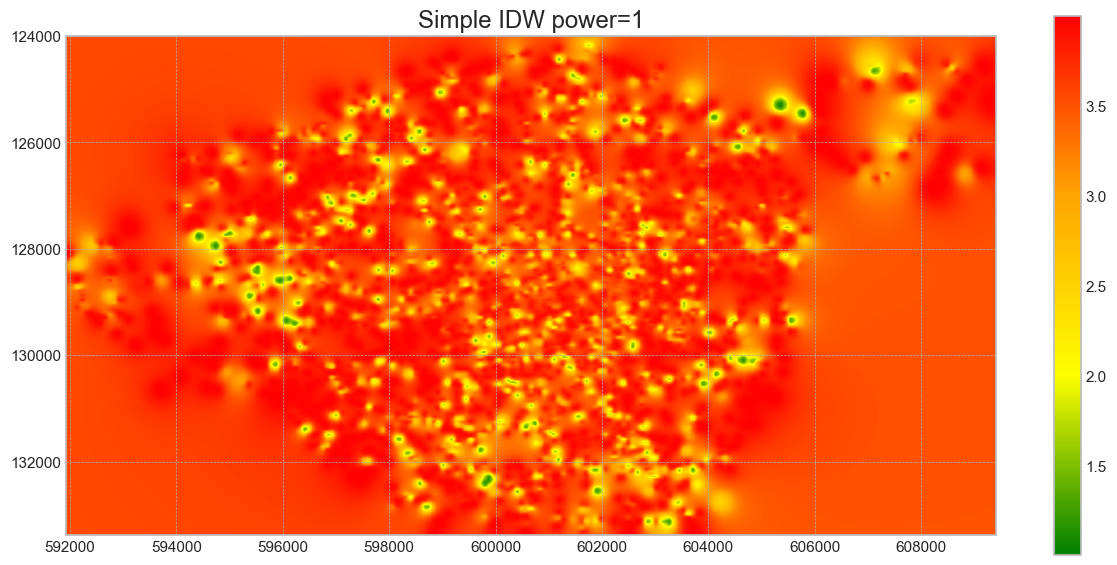

In [ ]:
 # Calculate IDW
 
# generate two arrays of evenly space data between ends of previous arrays
xi = np.linspace(min(accidents_paris.geometry.x), max(accidents_paris.geometry.x), 201)
yi = np.linspace(min(accidents_paris.geometry.y), max(accidents_paris.geometry.y), 201)

# generate grid 
xi, yi = np.meshgrid(xi, yi)

# colapse grid into 1D
xi, yi = xi.flatten(), yi.flatten()

coords_acc
# Create list of XY coordinate pairs and values of accidents
x,y = list(map(list,zip(*coords_acc)))
z = grav_accidents


grid1 = simple_idw(x,y,z,xi,yi, power=3)
grid1 = grid1.reshape((201, 201))
plot(x,y,z,grid1)
plt.title('Simple IDW power=1')
plt.show()
